# Alameda Cases

Alameda covid cases data: https://data.acgov.org/datasets/AC-HCSA::alameda-county-cumulative-cases-by-place-and-zip/data
Zip code population data: https://catalog.data.gov/dataset/2010-census-populations-by-zip-code
Median income data: http://www.healthyalamedacounty.org/indicators/index/view?indicatorId=15&localeId=5587

In [57]:
import numpy as np
import pandas as pd
from importlib import reload
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import optimize
import statsmodels.api as sm
#from adjustText import adjust_text
import os
import pickle
import requests
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.stats import pearsonr

from IPython.display import HTML
from modeling import dataproc, optimizer, sir_model

In [58]:
def plot_sir_model(r, i, s, sim_days, plot_days, df, metric, sampling_rate, name):
    """Plot the model death rates and total deaths vs actual data.
    
    Args:
        r: Array holding daily recovered population values from SIR model
        i: Array holding daily infected population values from SIR model
        s: Array holding daily susceptible population values from SIR model
        total_model_days: Total number of modeled days to plot
        df: Dataframe holding metric values.
        metric: The type of metric to plot ('Cases' or 'Deaths')
        sampling_rate: Number of samples per day used to simulate the model.
        name: A name to attach to the plot.
    """
    start_time = df.index.min().timestamp()
    step_size = 24 * 60 * 60 / sampling_rate
    plot_end_time = start_time + plot_days * 24 * 60 * 60 
    sim_end_time = start_time + sim_days * 24 * 60 * 60 
    plot_timestamps = np.arange(start_time, plot_end_time, step_size)
    sim_timestamps = np.arange(start_time, sim_end_time, step_size)
    plot_dates = [datetime.utcfromtimestamp(x) for x in plot_timestamps]
    sim_dates = [datetime.utcfromtimestamp(x) for x in sim_timestamps]
    print('peak infection rate date', sim_dates[np.argmax(i * s)])
    # Plot peak infection
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates[:-sampling_rate],
            (r[sampling_rate:len(plot_dates)] + i[sampling_rate:len(plot_dates)]
             - r[:len(plot_dates)-sampling_rate] - i[:len(plot_dates)-sampling_rate]),
            c='g',
            label='model ' + metric + ' rate',
            linewidth=4)
    ax.plot(df.index.to_list()[:-1],
            (df[metric] - df[metric].shift())[1:], label='actual ' + metric + ' rate', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.plot()
    
    # Plot recovery
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates, r[:len(plot_dates)] + i[:len(plot_dates)], c='g',
            label='model ' + metric, linewidth=4)
    ax.plot(df.index.to_list(), df[metric], label='actual ' + metric, c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.show()

In [59]:
# Income levels
alameda_income_df = pd.read_csv('data_repo/alameda_median_income.csv')
alameda_income_df = alameda_income_df[alameda_income_df['Period of Measure'] == '2014-2018']
alameda_income_df['Location'] = alameda_income_df['Location'].astype(str)
alameda_income_df = alameda_income_df.set_index('Location')
alameda_income_df

,Indicator Name,What Is This Indicator,Location Type,Indicator Value,Indicator Value Units,Lower Confidence Interval,Upper Confidence Interval,Indicator Value Unstable,Period of Measure,Data Source,Technical Note,Breakout Title,Breakout Category,Breakout Subcategory,Breakout Value,Breakout Value Units,Breakout Lower Confidence Interval,Breakout Upper Confidence Interval,Breakout Unstable,Breakout Footer
Location,,,,,,,,,,,,,,,,,,,,
94501,Per Capita Income,This indicator shows the per capita income.,Zip Code,46554,dollars,45053,48055,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94502,Per Capita Income,This indicator shows the per capita income.,Zip Code,58560,dollars,54113,63007,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94536,Per Capita Income,This indicator shows the per capita income.,Zip Code,46643,dollars,45148,48138,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94538,Per Capita Income,This indicator shows the per capita income.,Zip Code,41897,dollars,40565,43229,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94539,Per Capita Income,This indicator shows the per capita income.,Zip Code,61948,dollars,60090,63806,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94541,Per Capita Income,This indicator shows the per capita income.,Zip Code,31260,dollars,30230,32290,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94542,Per Capita Income,This indicator shows the per capita income.,Zip Code,42189,dollars,38906,45472,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94544,Per Capita Income,This indicator shows the per capita income.,Zip Code,28569,dollars,27715,29423,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94545,Per Capita Income,This indicator shows the per capita income.,Zip Code,31905,dollars,29383,34427,No,2014-2018,American Community Survey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Population and population density by zip code
pop_df = pd.read_csv('data_repo/uszips.csv')
pop_df['Location'] = pop_df['zip'].astype(str)
pop_df = pop_df.set_index('Location')
pop_df

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
Location,,,,,,,,,,,,,,,,,,
601,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
602,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
603,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
606,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
610,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,99923,55.97796,-130.03671,Hyder,AK,Alaska,True,NaN,15,2.1,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka
99925,99925,55.55767,-132.97627,Klawock,AK,Alaska,True,NaN,927,5.7,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Sitka
99926,99926,55.12617,-131.48928,Metlakatla,AK,Alaska,True,NaN,1635,4.2,2198,Prince of Wales-Hyder,{'02198':100},Prince of Wales-Hyder,02198,False,False,America/Metlakatla


In [61]:
# Station Addresses (add Warm Springs)
station_addresses_df = pd.read_csv('data_repo/bart_stations.csv')
station_addresses_df = station_addresses_df[station_addresses_df['county'] == 'alameda'][['name', 'zipcode']]
# Replace a lot of labels
station_addresses_df = station_addresses_df.replace(
    {'name': {
        '12th St. Oakland City Center': '12th Street / Oakland City Center',
        '19th St. Oakland': '19th Street Oakland',
        'Bay Fair': 'Bayfair',
        'Coliseum/Oakland Airport': 'Coliseum',
        'Downtown Berkeley': 'Berkeley',
    }}
)
station_addresses_df = station_addresses_df.set_index('name')
station_addresses_df.loc['Warm Springs'] = ['94539']
station_addresses_df

,zipcode
name,
12th Street / Oakland City Center,94612
19th Street Oakland,94612
Ashby,94703
Bayfair,94578
Castro Valley,94546
Coliseum,94621
Berkeley,94704
Dublin/Pleasanton,94588
Fremont,94536


In [62]:
# Station Names
bart_station_names_df = pd.read_excel('data_repo/Station_Names.xls')
del bart_station_names_df['Unnamed: 0']
bart_station_names_df = bart_station_names_df.set_index('Two-Letter Station Code')
bart_station_names_df = bart_station_names_df.join(station_addresses_df, on='Station Name')
bart_station_names_df = bart_station_names_df[~bart_station_names_df['zipcode'].isna()]
bart_station_names_df.sort_values('Station Name')

,Station Name,zipcode
Two-Letter Station Code,,
12,12th Street / Oakland City Center,94612
19,19th Street Oakland,94612
AS,Ashby,94703
BF,Bayfair,94578
BK,Berkeley,94704
CV,Castro Valley,94546
CL,Coliseum,94621
ED,Dublin/Pleasanton,94588
FM,Fremont,94536


In [63]:
# BART ridership
bart_activity_dict = pd.read_excel('data_repo/Ridership_202004.xlsx', sheet_name = None)
print(list(bart_activity_dict.keys()))
bart_entries_and_exits_dict = {}
for key, bart_activity_df in bart_activity_dict.items():
    new_header = bart_activity_df.iloc[0] #grab the first row for the header
    bart_activity_df = bart_activity_df[1:] #take the data less the header row
    new_header[0] = 'station'
    bart_activity_df.columns = new_header #set the header row as the df header
    bart_activity_df = bart_activity_df.set_index('station')
    bart_transposed_df = bart_activity_df.transpose()
    bart_entries_and_exits_dict[key] = (bart_activity_df, bart_transposed_df)
bart_entries_and_exits_dict['Total Trips OD'][1]

['Avg Weekday OD', 'Avg Saturday OD', 'Avg Sunday OD', 'Total Trips OD']


/Users/bfoo/env3/general/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


station,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SO,MB,WD,OA,WS,ML,BE,PC,AN,Entries
0,,,,,,,,,,,,,,,,,,,,,
RM,164,667,484,414,1205,482,805,485,659,195,...,151,80,23,12,48,0,0,116,78,17575
EN,675,160,372,327,1577,670,954,726,940,245,...,279,160,21,38,103,0,0,40,78,20602
EP,448,374,71,200,974,290,384,282,380,66,...,32,43,4,5,9,0,0,20,27,6953
NB,462,322,161,27,200,120,199,146,164,112,...,18,16,3,13,38,0,0,11,5,4634
BK,1004,1492,917,181,198,499,581,517,850,203,...,58,40,5,16,81,0,0,23,92,12267
AS,496,685,267,103,666,44,337,381,379,137,...,10,24,14,9,40,0,0,25,63,8157
MA,773,928,367,172,733,307,187,332,475,157,...,140,45,38,15,92,0,0,358,405,17249
19,411,673,343,180,635,343,360,99,128,80,...,66,47,44,16,135,0,0,126,237,14430
12,628,857,446,181,1123,455,635,124,182,111,...,125,68,31,26,158,0,0,169,270,20794


In [64]:
# Join all BART data together with zip code index
bart_df = bart_station_names_df.join(bart_entries_and_exits_dict['Total Trips OD'][0][['Exits']], how='inner')
bart_df = bart_df.join(bart_entries_and_exits_dict['Total Trips OD'][1][['Entries']], how='inner')
bart_df['zipcode'] = bart_df['zipcode'].astype(str)
bart_df.dtypes

Station Name    object
zipcode         object
Exits           object
Entries         object
dtype: object

In [65]:
# Aggregate data by zip code
bart_zip_df = bart_df[['zipcode', 'Entries', 'Exits']].groupby('zipcode').sum()
bart_zip_df = bart_zip_df.rename(columns={'Entries': 'Bart entries', 'Exits': 'Bart exits'})
bart_zip_df

,Bart entries,Bart exits
zipcode,,
94536,7101,8005
94539,4332,4490
94541,11911,12343
94544,9067,8519
94546,4744,4747
94568,2784,2958
94577,18114,18240
94578,15860,15906
94587,8191,7442


In [66]:
alameda_df = pd.read_csv('data_repo/Alameda_County_Cumulative_Cases_By_Place_And_Zip.csv')
# Replace < 10 with 0
alameda_df.replace({'<10': 0}, inplace=True)
alameda_df = alameda_df.fillna(0)
# Convert date column to datetime
alameda_df['Date'] = alameda_df['DtCreate'].apply(lambda x: datetime.strptime(x.split(' ')[0], '%Y/%m/%d'))
del alameda_df['DtCreate']
del alameda_df['ObjectId']
col_rename = {col: col[1:] for col in list(alameda_df) if 'F9' in col}
alameda_df = alameda_df.rename(columns=col_rename)
# Convert columns to rows
alameda_df = alameda_df.melt(['Date'], var_name='Location', value_name='Cases')
alameda_df = alameda_df.set_index('Date')
alameda_df['Cases'] = alameda_df['Cases'].astype(int)
alameda_df.index.unique()

DatetimeIndex(['2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08',
               ...
               '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23',
               '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27',
               '2020-06-28', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=123, freq=None)

In [67]:
# Do some joining
# Get only locations with cases
locations_with_cases = alameda_df[
    (alameda_df.index == '2020-06-03')
    & (alameda_df['Cases'] > 0)
    & (alameda_df['Location'].str.contains('9'))
]

# Join with population
locations_with_cases = locations_with_cases.join(pop_df[['city', 'population', 'density']],
                          on='Location', how='left')
locations_with_cases['Frac Cases'] = locations_with_cases['Cases'] / locations_with_cases['population']

# Join with median income
locations_with_cases = locations_with_cases.join(alameda_income_df[['Indicator Value']],
                                                 on='Location', how='left')

locations_with_cases = locations_with_cases.rename(columns={'Indicator Value': 'Median Income'})

locations_with_cases['Location'] = locations_with_cases['Location'].astype(str)

# Filter some of the very small values
#locations_with_cases = locations_with_cases[locations_with_cases['Cases'] >= 20]
locations_with_cases = locations_with_cases.join(bart_zip_df, on='Location', how='left')

locations_with_cases.sort_values('Median Income')

,Location,Cases,city,population,density,Frac Cases,Median Income,Bart entries,Bart exits
Date,,,,,,,,,
2020-06-03,94621,215,Oakland,35287,1483.2,0.006093,15973,20597.0,20872.0
2020-06-03,94603,187,Oakland,34593,3717.4,0.005406,19338,NaN,NaN
2020-06-03,94704,11,Berkeley,29190,9255.7,0.000377,19692,12267.0,13736.0
2020-06-03,94601,464,Oakland,52299,5979.9,0.008872,20335,28713.0,28646.0
2020-06-03,94544,444,Hayward,79235,2573.4,0.005604,28569,9067.0,8519.0
2020-06-03,94578,101,San Leandro,41059,3316.5,0.002460,29062,15860.0,15906.0
2020-06-03,94606,111,Oakland,38303,6190.0,0.002898,29339,NaN,NaN
2020-06-03,94541,250,Hayward,66056,3204.8,0.003785,31260,11911.0,12343.0
2020-06-03,94545,107,Hayward,32525,532.2,0.003290,31905,NaN,NaN


Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 15960.75
Fraction of infected/recovered population currently infected at start of simulation: 0.26624988198509947
Final population affected (e.g. dead) since start of simulation: 1980.703599437229
Final population affected (e.g. dead) overall: 2028.703599437229
Current and final herd immunity level: 0.004699027301348621 0.1270247192035354
Transmissions per person per day: 0.11046713548704545
First day estimate multiplier 0.9730455748041135
R0 (initial transmit rate / recovery rate) 1.1046713548704545
R (current transmit rate / recovery rate) 1.0994804740149005
Training MSE 1.0990012174798172
Validation MSE 1.0990012174798172
Date
2020-06-03    1.09948
Name: R, dtype: float64
peak infection rate date 2021-03-20 12:00:00


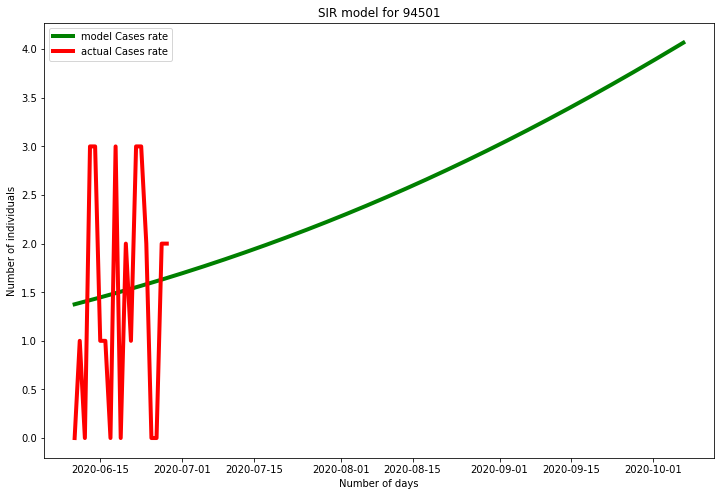

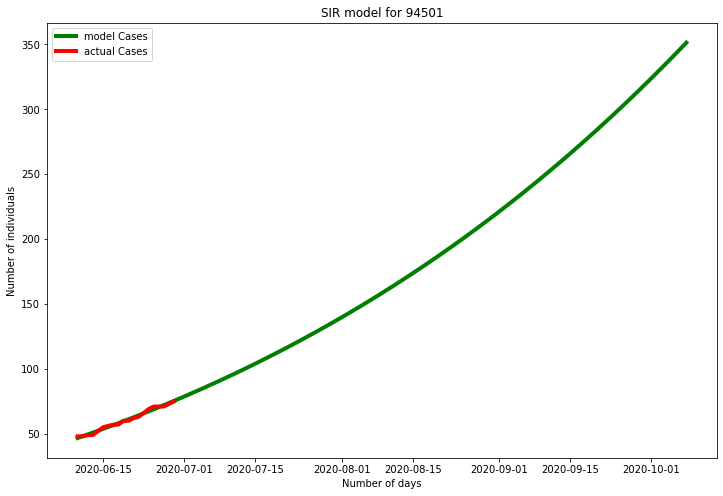

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 3654.75
Fraction of infected/recovered population currently infected at start of simulation: 0.01
Final population affected (e.g. dead) since start of simulation: 2828.237892980851
Final population affected (e.g. dead) overall: 2838.237892980851
Current and final herd immunity level: 0.0030097817908201654 0.7765319107172156
Transmissions per person per day: 0.1931127129775793
First day estimate multiplier 0.9792107712892699
R0 (initial transmit rate / recovery rate) 1.9311271297757928
R (current transmit rate / recovery rate) 1.925314858504835
Training MSE 0.05795810470706565
Validation MSE 0.05795810470706565
Date
2020-06-03    1.925315
Name: R, dtype: float64
peak infection rate date 2020-09-21 00:00:00


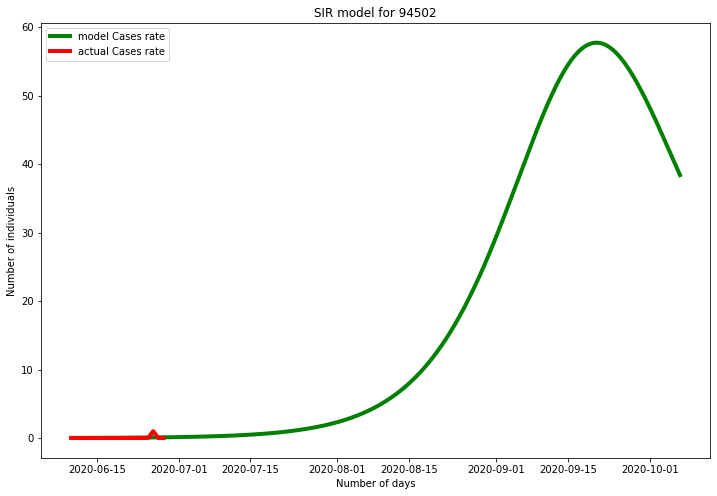

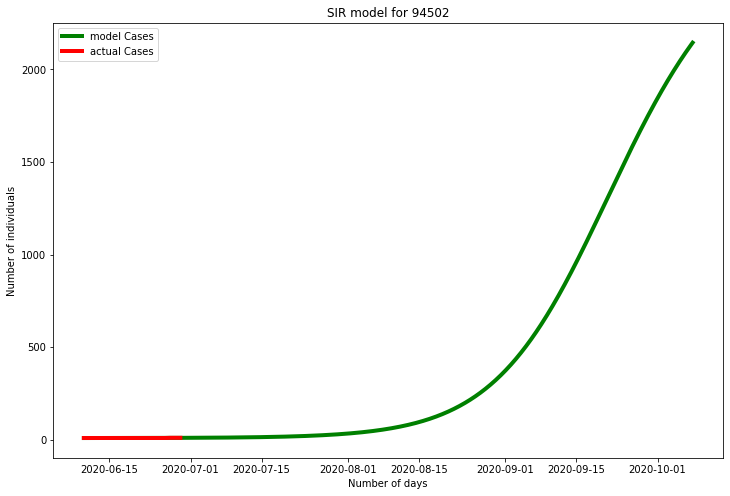

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 18463.75
Fraction of infected/recovered population currently infected at start of simulation: 0.06967636539520747
Final population affected (e.g. dead) since start of simulation: 13278.644423955
Final population affected (e.g. dead) overall: 13336.644423955
Current and final herd immunity level: 0.005307697515401801 0.7225602633972394
Transmissions per person per day: 0.17763330012704284
First day estimate multiplier 1.0780627473410098
R0 (initial transmit rate / recovery rate) 1.7763330012704284
R (current transmit rate / recovery rate) 1.766904763013059
Training MSE 2.9949490323570545
Validation MSE 2.9949490323570545
Date
2020-06-03    1.766905
Name: R, dtype: float64
peak infection rate date 2020-09-11 04:48:00


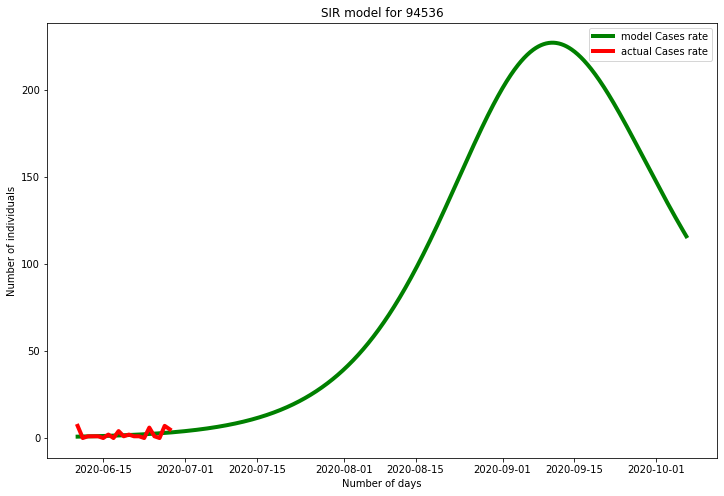

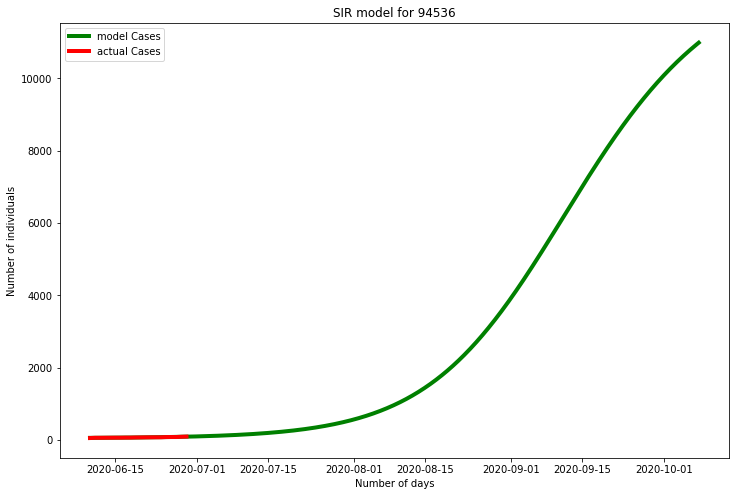

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 17027.75
Fraction of infected/recovered population currently infected at start of simulation: 0.06752762128474327
Final population affected (e.g. dead) since start of simulation: 10277.082856351079
Final population affected (e.g. dead) overall: 10367.082856351079
Current and final herd immunity level: 0.006812409155642994 0.6087719224913634
Transmissions per person per day: 0.1544834981065509
First day estimate multiplier 0.9881471872359417
R0 (initial transmit rate / recovery rate) 1.544834981065509
R (current transmit rate / recovery rate) 1.534310933096541
Training MSE 3.087636709776681
Validation MSE 3.087636709776681
Date
2020-06-03    1.534311
Name: R, dtype: float64
peak infection rate date 2020-10-06 19:12:00


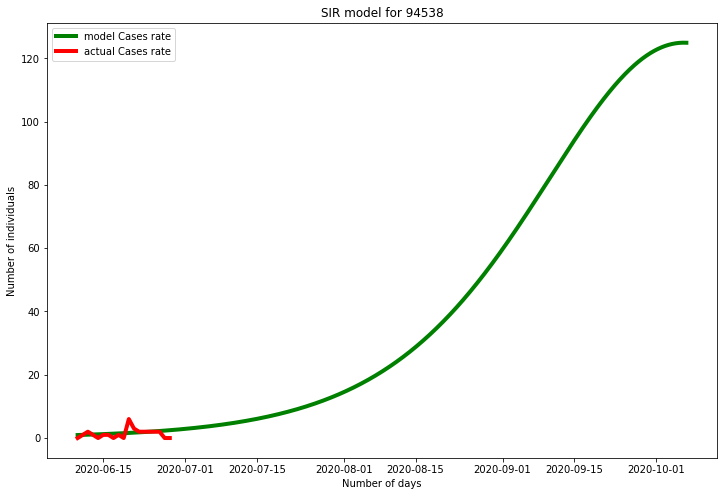

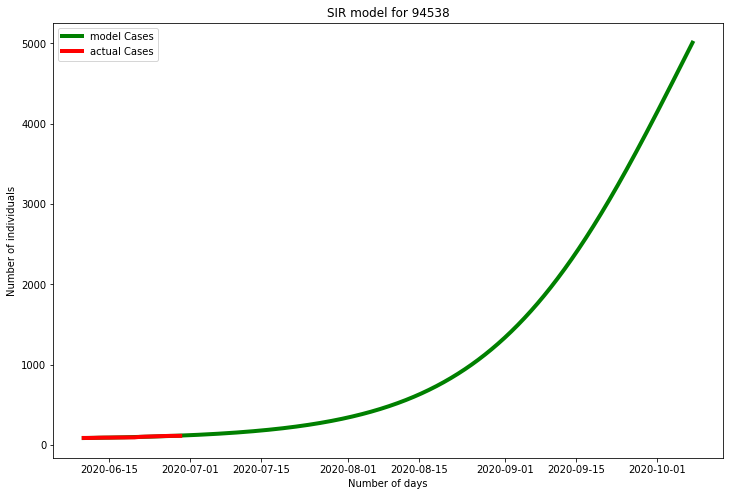

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 13200.5
Fraction of infected/recovered population currently infected at start of simulation: 0.09479358933101285
Final population affected (e.g. dead) since start of simulation: 62.81827157559928
Final population affected (e.g. dead) overall: 95.81827157559928
Current and final herd immunity level: 0.0029544335441839325 0.0072469034312881
Transmissions per person per day: 0.09706679009198206
First day estimate multiplier 0.9952871869429568
R0 (initial transmit rate / recovery rate) 0.9706679009198206
R (current transmit rate / recovery rate) 0.9678001271130805
Training MSE 0.38290487606314105
Validation MSE 0.38290487606314105
Date
2020-06-03    0.9678
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


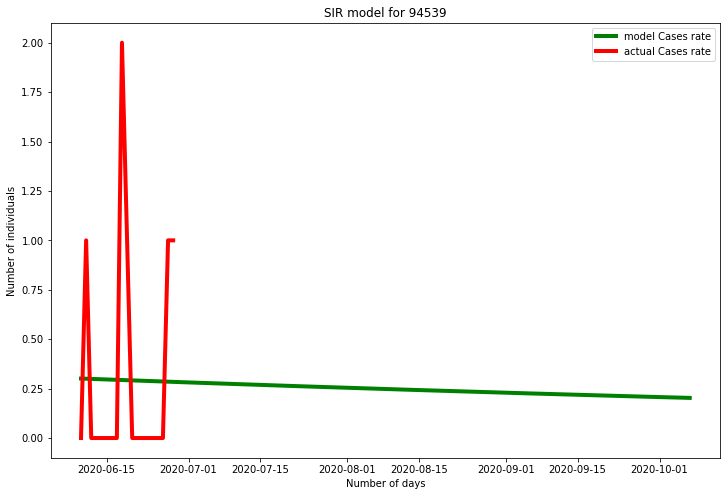

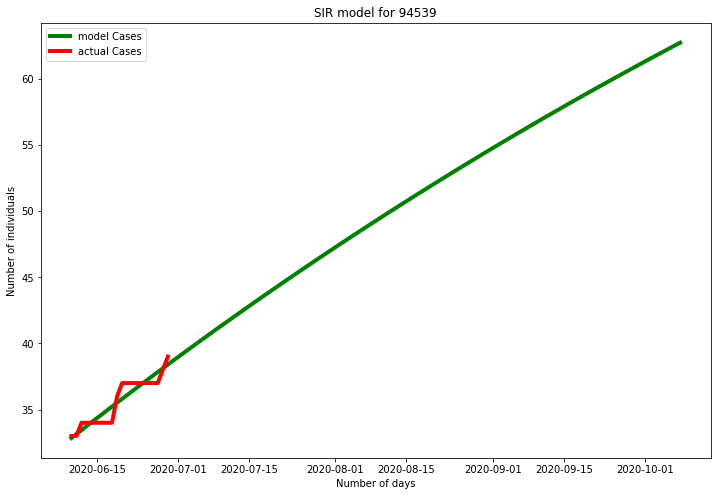

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 16514.0
Fraction of infected/recovered population currently infected at start of simulation: 0.21302613728849862
Final population affected (e.g. dead) since start of simulation: 2045.023677296631
Final population affected (e.g. dead) overall: 2334.023677296631
Current and final herd immunity level: 0.0247668644786242 0.14134005108415224
Transmissions per person per day: 0.10665363683968919
First day estimate multiplier 1.0002281187095494
R0 (initial transmit rate / recovery rate) 1.0665363683968918
R (current transmit rate / recovery rate) 1.040121606699282
Training MSE 16.747377518786557
Validation MSE 16.747377518786557
Date
2020-06-03    1.040122
Name: R, dtype: float64
peak infection rate date 2020-09-07 16:48:00


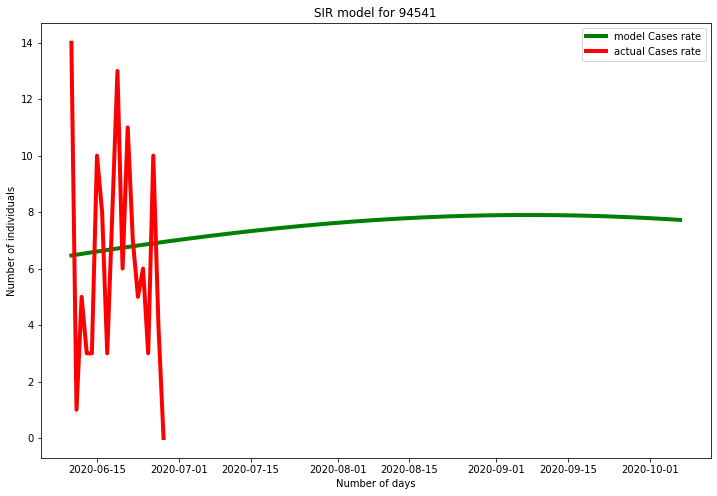

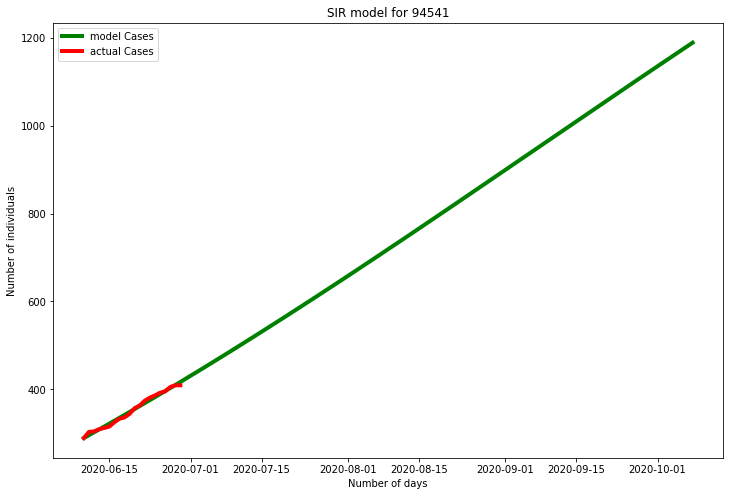

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 3554.25
Fraction of infected/recovered population currently infected at start of simulation: 0.01
Final population affected (e.g. dead) since start of simulation: 3224.448297250569
Final population affected (e.g. dead) overall: 3258.448297250569
Current and final herd immunity level: 0.013223605542660196 0.9166931681877463
Transmissions per person per day: 0.27222863653553175
First day estimate multiplier 0.9914234053155341
R0 (initial transmit rate / recovery rate) 2.7222863653553175
R (current transmit rate / recovery rate) 2.6862879242856965
Training MSE 0.3752223718534647
Validation MSE 0.3752223718534647
Date
2020-06-03    2.686288
Name: R, dtype: float64
peak infection rate date 2020-07-31 07:12:00


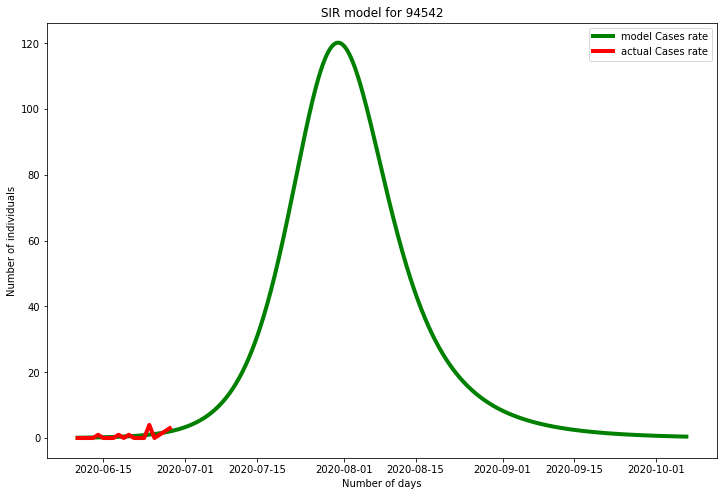

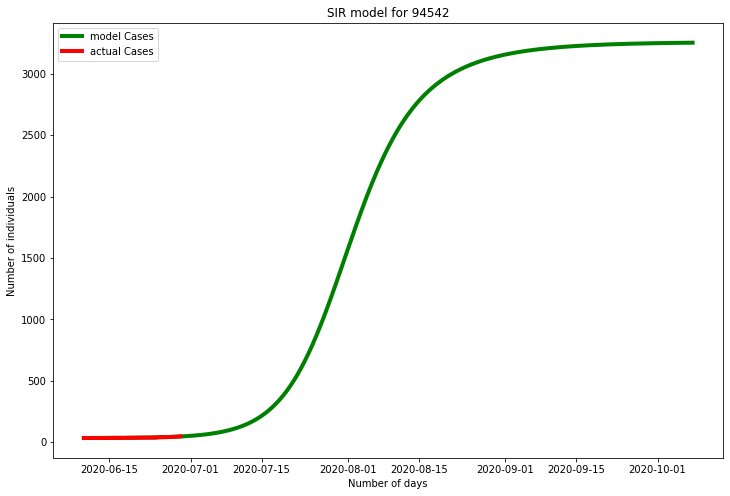

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 19808.75
Fraction of infected/recovered population currently infected at start of simulation: 0.7212206631872112
Final population affected (e.g. dead) since start of simulation: 277.08262410170573
Final population affected (e.g. dead) overall: 756.0826241017057
Current and final herd immunity level: 0.03271281630592541 0.03768357083765263
Transmissions per person per day: 0.046434342884624086
First day estimate multiplier 0.9799202708322468
R0 (initial transmit rate / recovery rate) 0.46434342884624086
R (current transmit rate / recovery rate) 0.44915344755553027
Training MSE 35.028246868940016
Validation MSE 35.028246868940016
Date
2020-06-03    0.449153
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


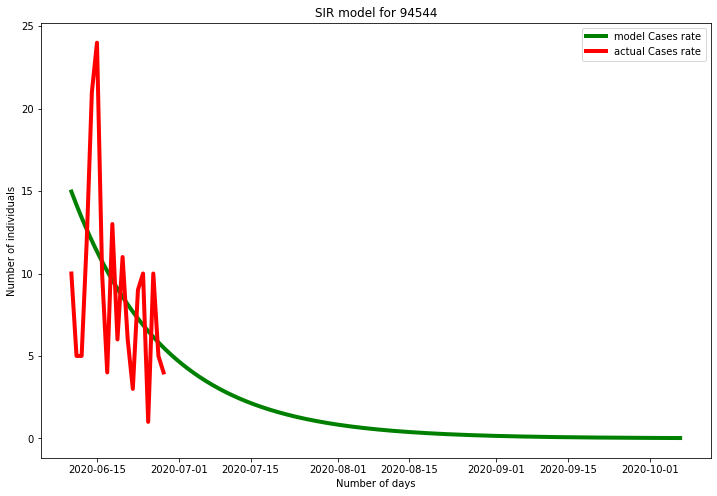

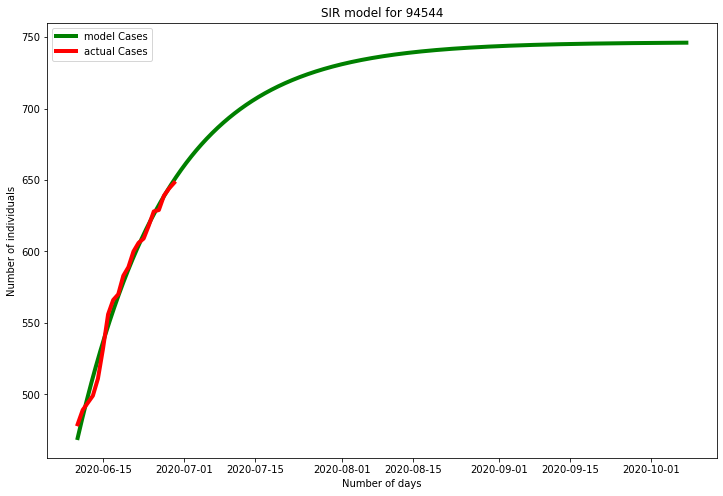

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 8131.25
Fraction of infected/recovered population currently infected at start of simulation: 0.09813626763071112
Final population affected (e.g. dead) since start of simulation: 2388.047067384641
Final population affected (e.g. dead) overall: 2501.047067384641
Current and final herd immunity level: 0.01721752498078401 0.3073956749357933
Transmissions per person per day: 0.12080762099578975
First day estimate multiplier 0.9864072074073205
R0 (initial transmit rate / recovery rate) 1.2080762099578974
R (current transmit rate / recovery rate) 1.1872761276342565
Training MSE 1.2708293885665722
Validation MSE 1.2708293885665722
Date
2020-06-03    1.187276
Name: R, dtype: float64
peak infection rate date 2020-12-07 02:24:00


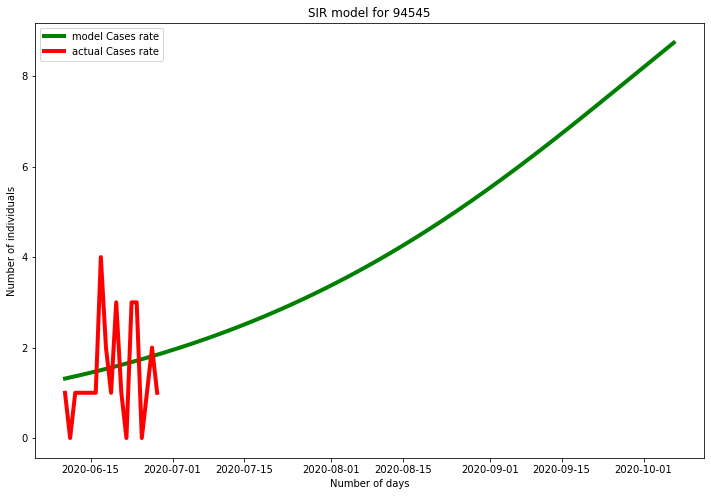

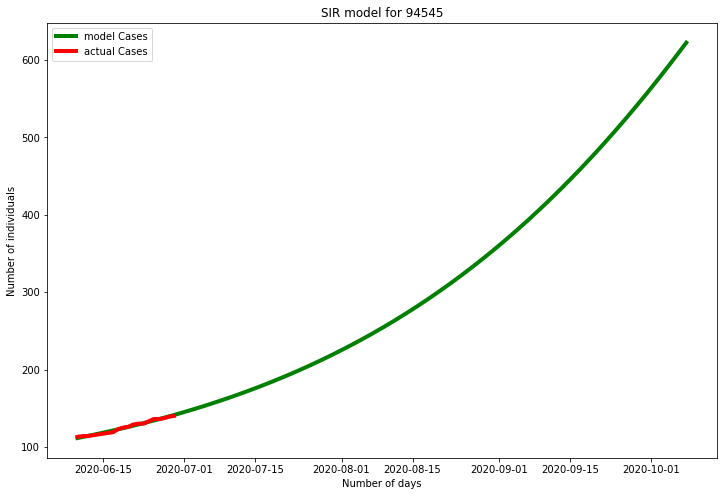

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11068.0
Fraction of infected/recovered population currently infected at start of simulation: 0.29224291558100024
Final population affected (e.g. dead) since start of simulation: 401.8648608100739
Final population affected (e.g. dead) overall: 496.8648608100739
Current and final herd immunity level: 0.013100831225153596 0.045026123001396946
Transmissions per person per day: 0.09662063704480861
First day estimate multiplier 1.0156238796777528
R0 (initial transmit rate / recovery rate) 0.9662063704480861
R (current transmit rate / recovery rate) 0.9535482638601775
Training MSE 2.274343217835576
Validation MSE 2.274343217835576
Date
2020-06-03    0.953548
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


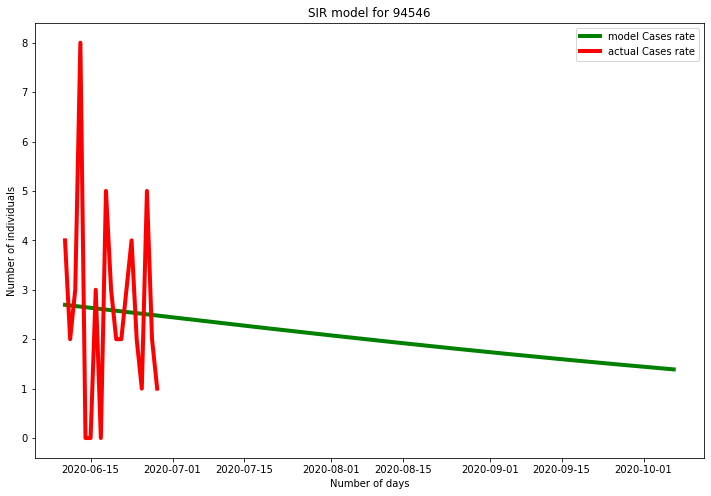

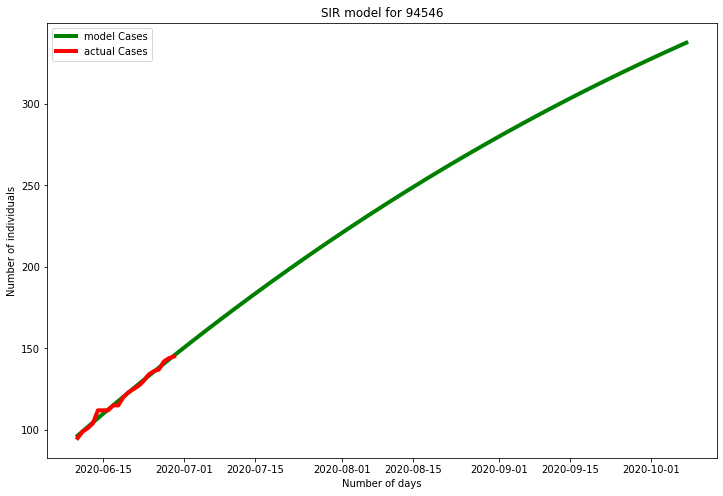

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 12625.0
Fraction of infected/recovered population currently infected at start of simulation: 0.9673259982216372
Final population affected (e.g. dead) since start of simulation: 4214.025676893047
Final population affected (e.g. dead) overall: 4246.025676893047
Current and final herd immunity level: 0.007683168316831683 0.3358983708528236
Transmissions per person per day: 0.12168811140649981
First day estimate multiplier 0.8341017226203548
R0 (initial transmit rate / recovery rate) 1.216881114064998
R (current transmit rate / recovery rate) 1.2075316116440629
Training MSE 10.193382561962972
Validation MSE 10.193382561962972
Date
2020-06-03    1.207532
Name: R, dtype: float64
peak infection rate date 2020-11-06 12:00:00


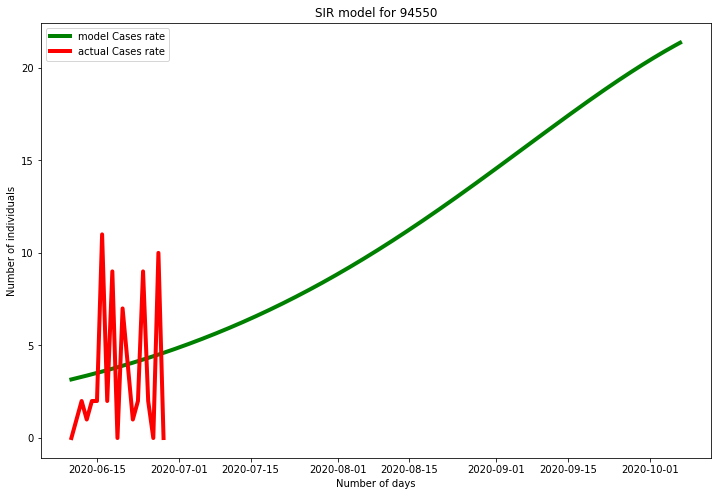

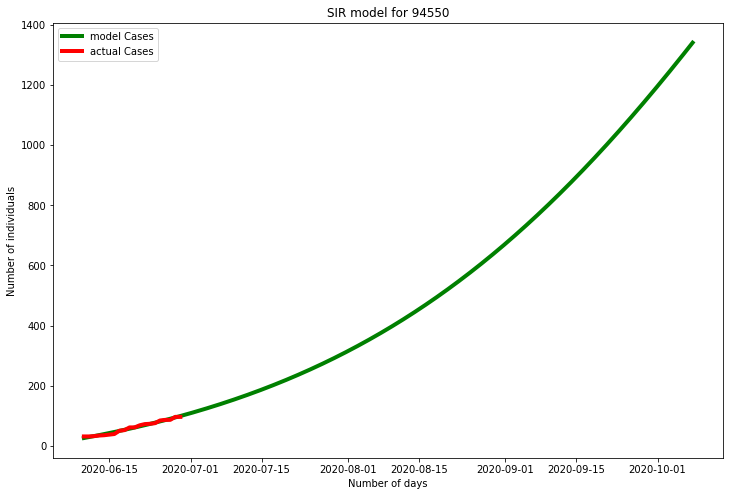

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11438.25
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 2448.517323714521
Final population affected (e.g. dead) overall: 2475.517323714521
Current and final herd immunity level: 0.006556947085437021 0.2160721153344687
Transmissions per person per day: 0.11321357746458809
First day estimate multiplier 0.8507240559246588
R0 (initial transmit rate / recovery rate) 1.1321357746458809
R (current transmit rate / recovery rate) 1.1247124202779977
Training MSE 9.128318392119649
Validation MSE 9.128318392119649
Date
2020-06-03    1.124712
Name: R, dtype: float64
peak infection rate date 2020-12-07 00:00:00


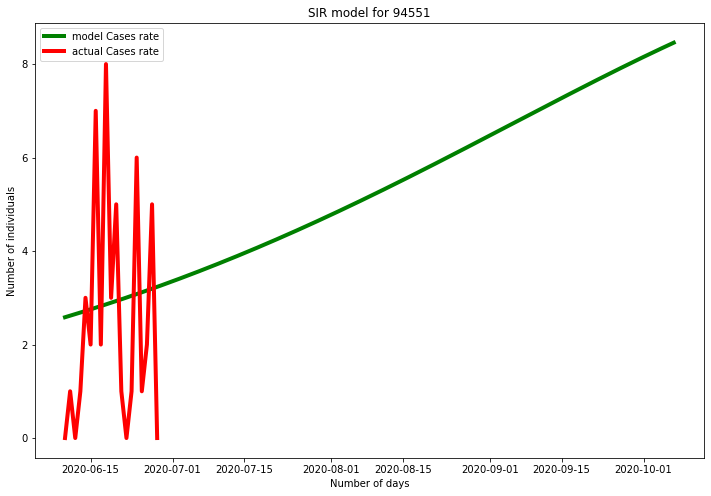

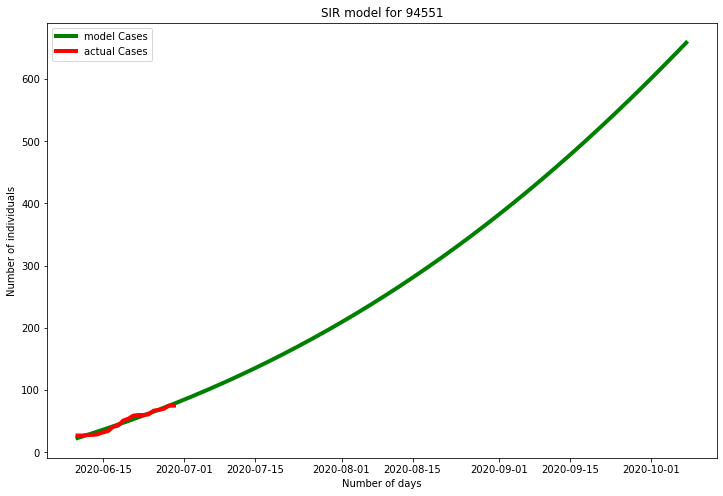

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 3853.0
Fraction of infected/recovered population currently infected at start of simulation: 0.01
Final population affected (e.g. dead) since start of simulation: 2883.262399693868
Final population affected (e.g. dead) overall: 2901.262399693868
Current and final herd immunity level: 0.005190760446405399 0.7529014362915714
Transmissions per person per day: 0.18604378171569888
First day estimate multiplier 0.9814907965309062
R0 (initial transmit rate / recovery rate) 1.8604378171569889
R (current transmit rate / recovery rate) 1.8507807301226935
Training MSE 0.11053134800299051
Validation MSE 0.11053134800299051
Date
2020-06-03    1.850781
Name: R, dtype: float64
peak infection rate date 2020-09-22 19:12:00


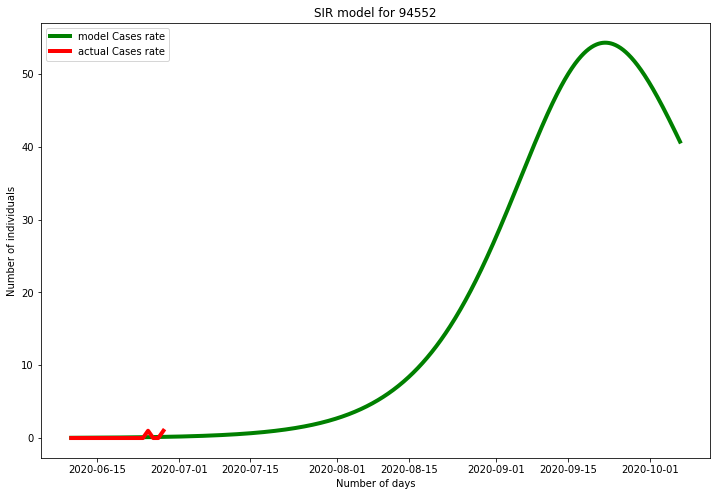

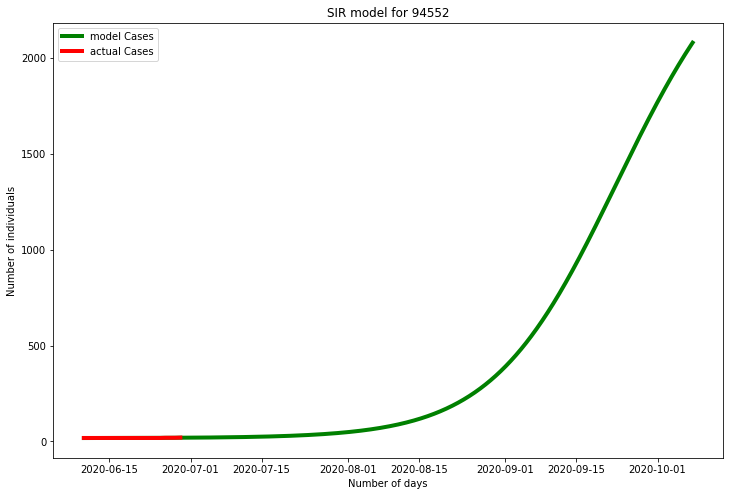

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9597.0
Fraction of infected/recovered population currently infected at start of simulation: 0.039324963369743136
Final population affected (e.g. dead) since start of simulation: 6639.959907432294
Final population affected (e.g. dead) overall: 6668.959907432294
Current and final herd immunity level: 0.0036469730123997084 0.6948328216419929
Transmissions per person per day: 0.17099347365959974
First day estimate multiplier 0.9776097195141993
R0 (initial transmit rate / recovery rate) 1.7099347365959974
R (current transmit rate / recovery rate) 1.7036986507586669
Training MSE 0.28001873776894737
Validation MSE 0.28001873776894737
Date
2020-06-03    1.703699
Name: R, dtype: float64
peak infection rate date 2020-09-28 16:48:00


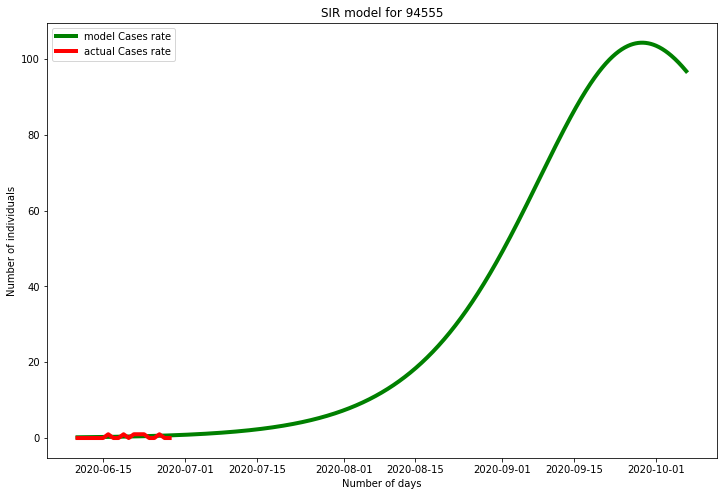

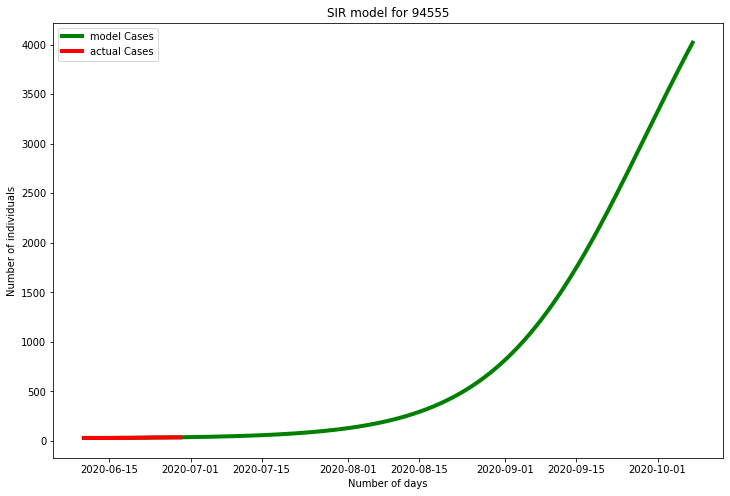

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11569.0
Fraction of infected/recovered population currently infected at start of simulation: 0.18400807793235693
Final population affected (e.g. dead) since start of simulation: 1194.4104137991453
Final population affected (e.g. dead) overall: 1317.4104137991453
Current and final herd immunity level: 0.013916500994035786 0.11347656483019357
Transmissions per person per day: 0.10691202878961004
First day estimate multiplier 0.9626013391980841
R0 (initial transmit rate / recovery rate) 1.0691202878961004
R (current transmit rate / recovery rate) 1.0542418743468505
Training MSE 10.829250558394856
Validation MSE 10.829250558394856
Date
2020-06-03    1.054242
Name: R, dtype: float64
peak infection rate date 2020-12-04 14:24:00


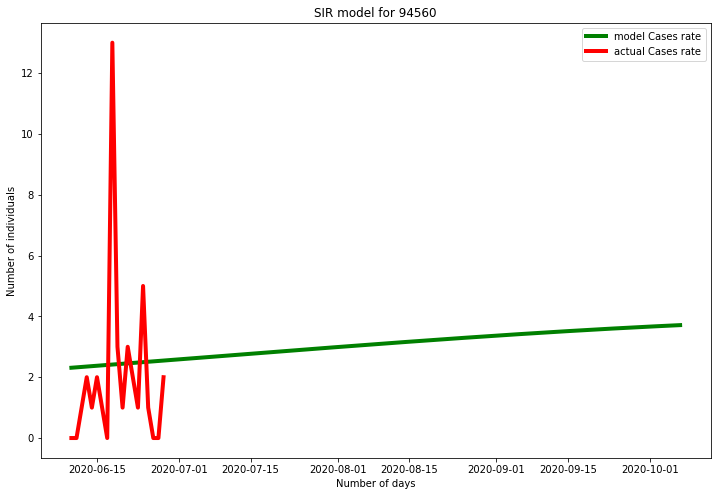

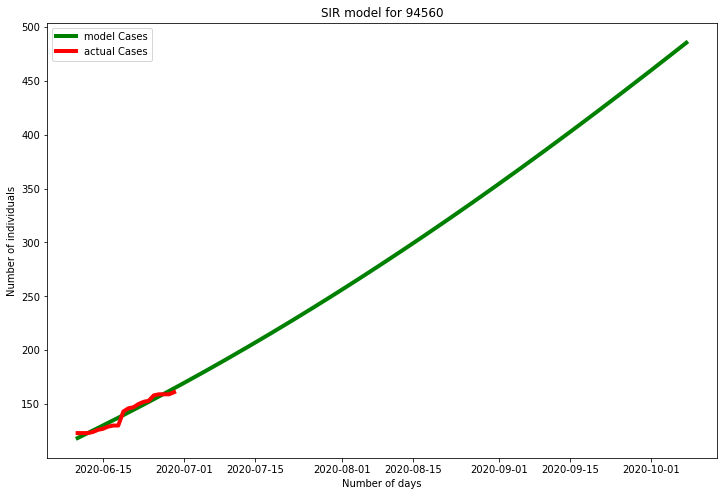

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 11477.5
Fraction of infected/recovered population currently infected at start of simulation: 0.09760788572429081
Final population affected (e.g. dead) since start of simulation: 7989.706838700109
Final population affected (e.g. dead) overall: 8027.706838700109
Current and final herd immunity level: 0.005140492267479852 0.6993092689863518
Transmissions per person per day: 0.17198819615651004
First day estimate multiplier 0.9635604234406274
R0 (initial transmit rate / recovery rate) 1.7198819615651004
R (current transmit rate / recovery rate) 1.711040921640697
Training MSE 1.7228956141067022
Validation MSE 1.7228956141067022
Date
2020-06-03    1.711041
Name: R, dtype: float64
peak infection rate date 2020-09-13 12:00:00


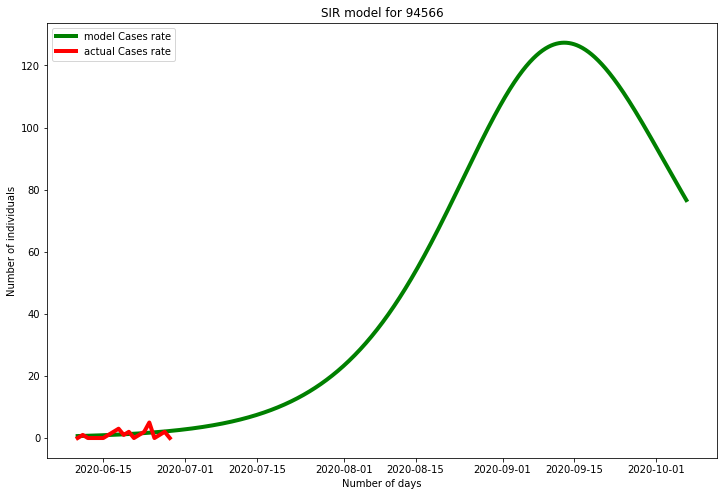

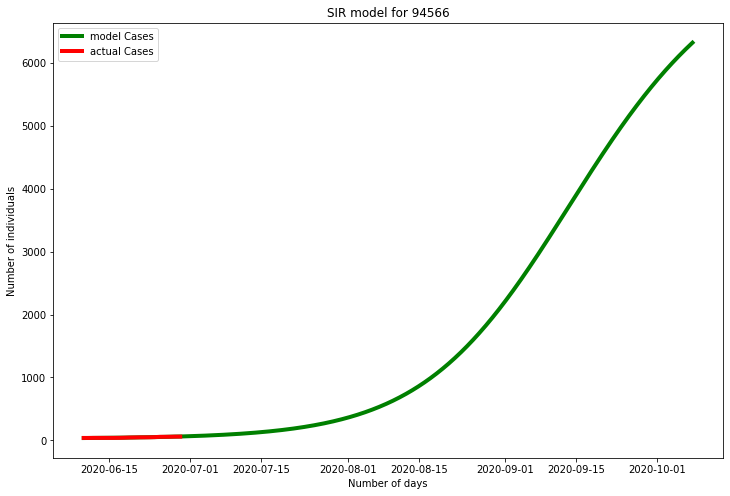

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 13605.0
Fraction of infected/recovered population currently infected at start of simulation: 0.172798970964691
Final population affected (e.g. dead) since start of simulation: 227.2739669073926
Final population affected (e.g. dead) overall: 314.2739669073926
Current and final herd immunity level: 0.00830576993752297 0.023070322619528433
Transmissions per person per day: 0.09599550678276723
First day estimate multiplier 0.995376693463128
R0 (initial transmit rate / recovery rate) 0.9599550678276724
R (current transmit rate / recovery rate) 0.9519819018839365
Training MSE 1.2566610377702305
Validation MSE 1.2566610377702305
Date
2020-06-03    0.951982
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


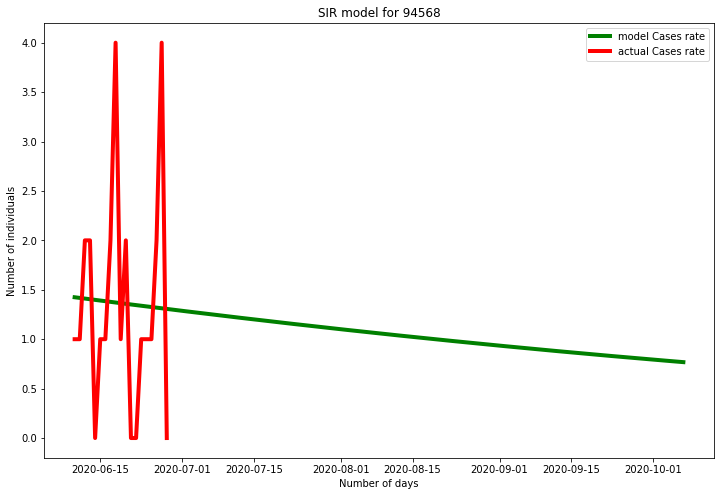

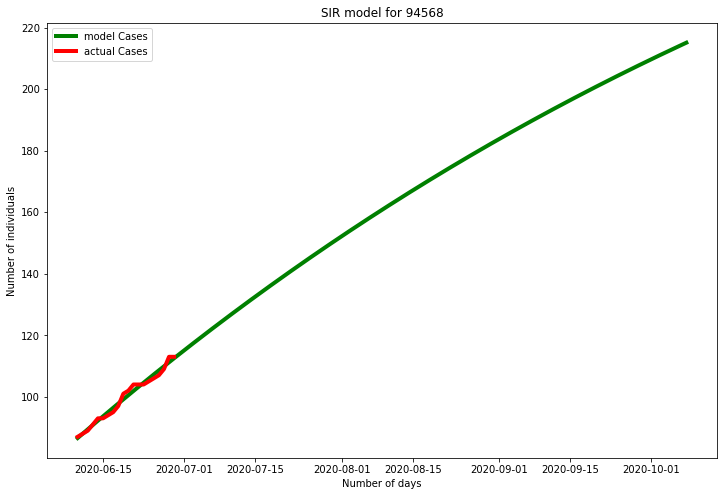

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 12022.0
Fraction of infected/recovered population currently infected at start of simulation: 0.19494096111097428
Final population affected (e.g. dead) since start of simulation: 4387.249856477086
Final population affected (e.g. dead) overall: 4490.249856477086
Current and final herd immunity level: 0.012976210281151222 0.37334251664616747
Transmissions per person per day: 0.12551405802393695
First day estimate multiplier 0.9812997926518342
R0 (initial transmit rate / recovery rate) 1.2551405802393694
R (current transmit rate / recovery rate) 1.2388536121377771
Training MSE 7.981390978901939
Validation MSE 7.981390978901939
Date
2020-06-03    1.238854
Name: R, dtype: float64
peak infection rate date 2020-11-06 14:24:00


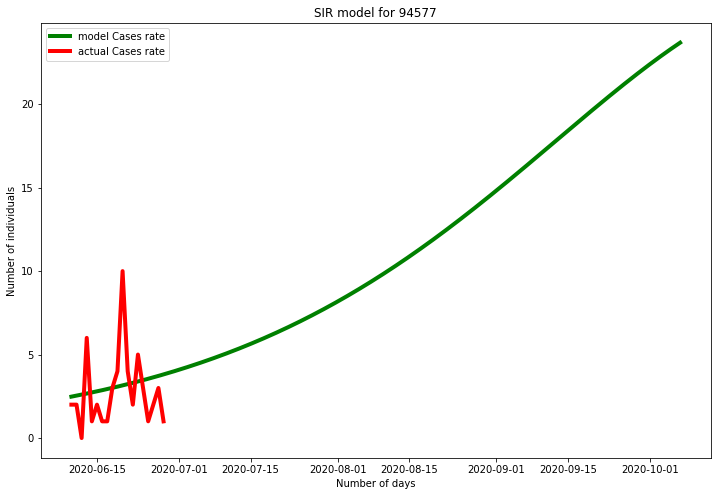

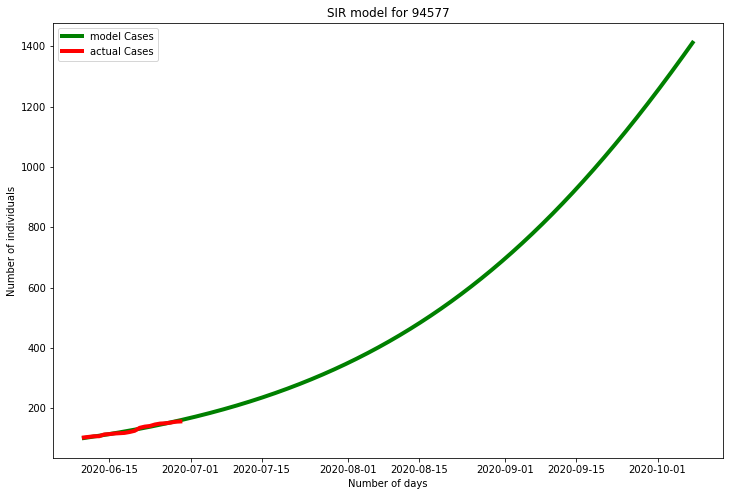

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 10264.75
Fraction of infected/recovered population currently infected at start of simulation: 0.1863745647899832
Final population affected (e.g. dead) since start of simulation: 4344.768337394094
Final population affected (e.g. dead) overall: 4466.768337394094
Current and final herd immunity level: 0.018802211451813246 0.4350885878733902
Transmissions per person per day: 0.13150329288131046
First day estimate multiplier 0.9943216801580953
R0 (initial transmit rate / recovery rate) 1.3150329288131046
R (current transmit rate / recovery rate) 1.2903074016194633
Training MSE 6.291986090980091
Validation MSE 6.291986090980091
Date
2020-06-03    1.290307
Name: R, dtype: float64
peak infection rate date 2020-10-10 07:12:00


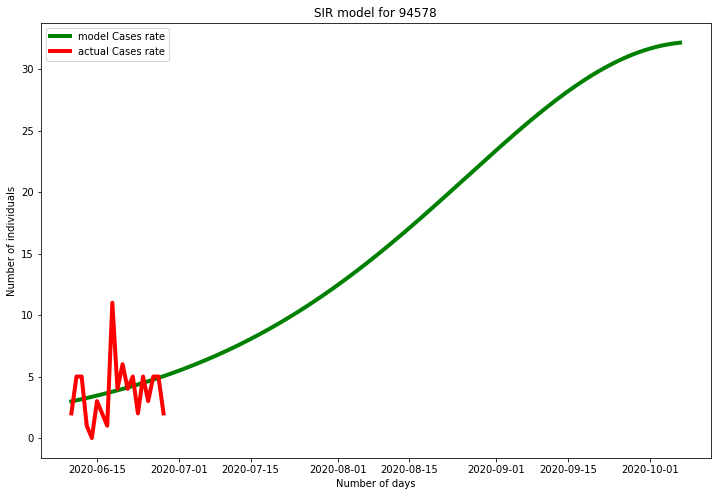

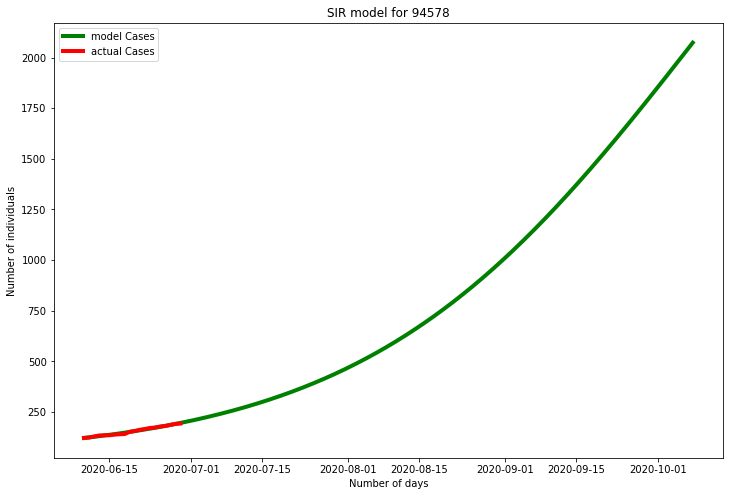

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5510.0
Fraction of infected/recovered population currently infected at start of simulation: 0.02156168257037972
Final population affected (e.g. dead) since start of simulation: 4393.105007842099
Final population affected (e.g. dead) overall: 4430.105007842099
Current and final herd immunity level: 0.00852994555353902 0.8041025768972723
Transmissions per person per day: 0.2033531098607935
First day estimate multiplier 1.0135186719424685
R0 (initial transmit rate / recovery rate) 2.033531098607935
R (current transmit rate / recovery rate) 2.0161851890553812
Training MSE 0.3844496767588994
Validation MSE 0.3844496767588994
Date
2020-06-03    2.016185
Name: R, dtype: float64
peak infection rate date 2020-08-26 12:00:00


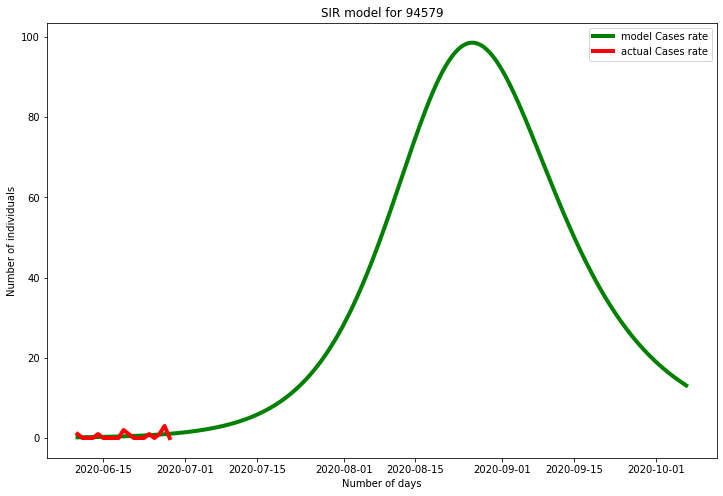

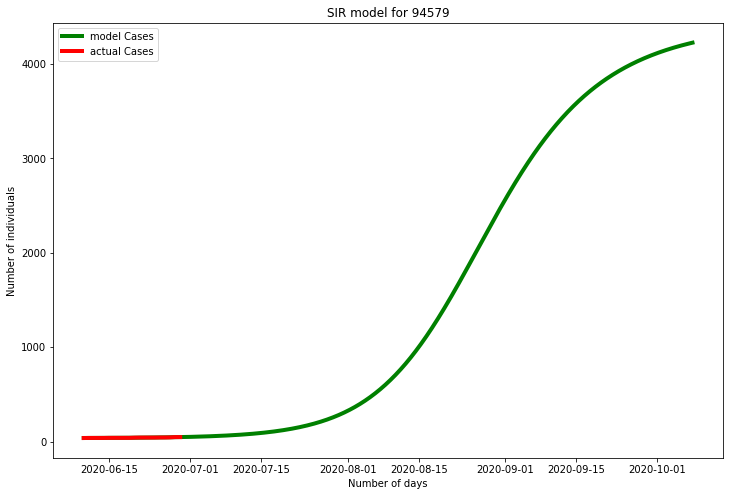

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7485.5
Fraction of infected/recovered population currently infected at start of simulation: 0.99
Final population affected (e.g. dead) since start of simulation: 42.7833540578431
Final population affected (e.g. dead) overall: 114.7833540578431
Current and final herd immunity level: 0.013759935876026986 0.015182281849139674
Transmissions per person per day: 0.03835451343743961
First day estimate multiplier 0.984216898942932
R0 (initial transmit rate / recovery rate) 0.38354513437439613
R (current transmit rate / recovery rate) 0.3782675779198423
Training MSE 2.2413285482042253
Validation MSE 2.2413285482042253
Date
2020-06-03    0.378268
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


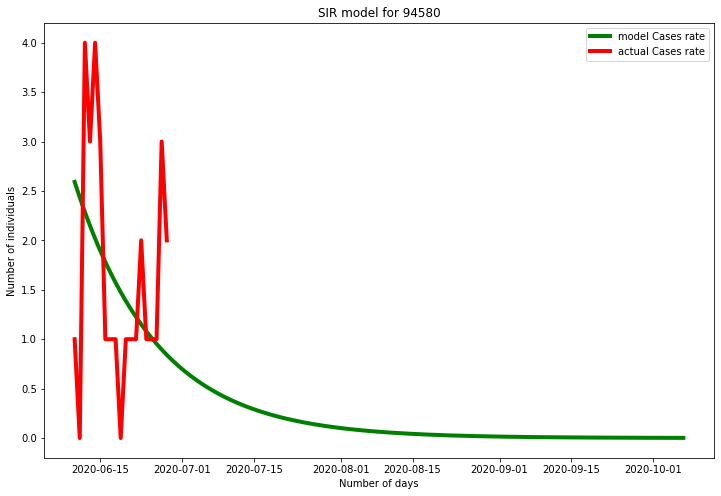

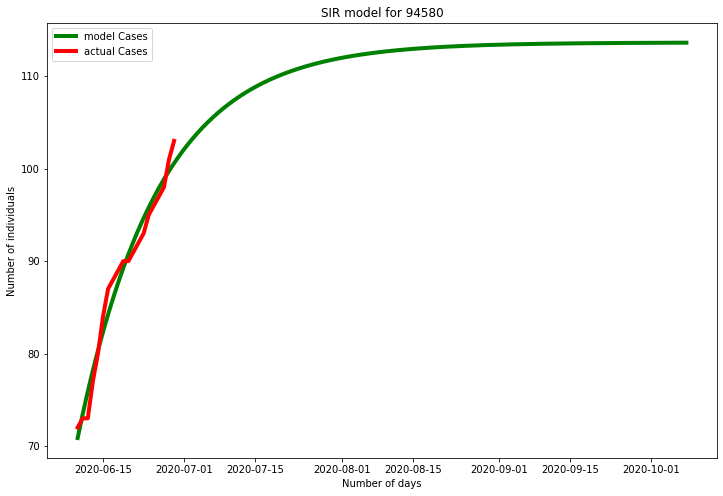

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 18650.25
Fraction of infected/recovered population currently infected at start of simulation: 0.09276528420239923
Final population affected (e.g. dead) since start of simulation: 8631.843252408618
Final population affected (e.g. dead) overall: 8779.843252408618
Current and final herd immunity level: 0.010348386750847843 0.4707195104417995
Transmissions per person per day: 0.13563081558000306
First day estimate multiplier 0.9945493054632008
R0 (initial transmit rate / recovery rate) 1.3563081558000305
R (current transmit rate / recovery rate) 1.3422725544504825
Training MSE 2.9588840756218446
Validation MSE 2.9588840756218446
Date
2020-06-03    1.342273
Name: R, dtype: float64
peak infection rate date 2020-11-03 02:24:00


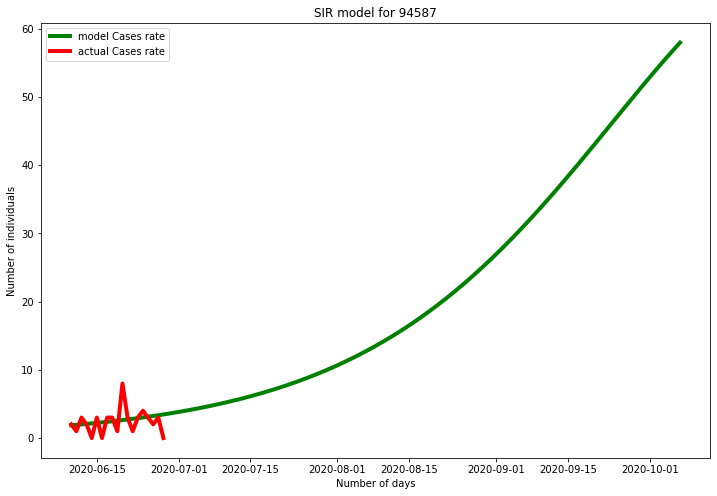

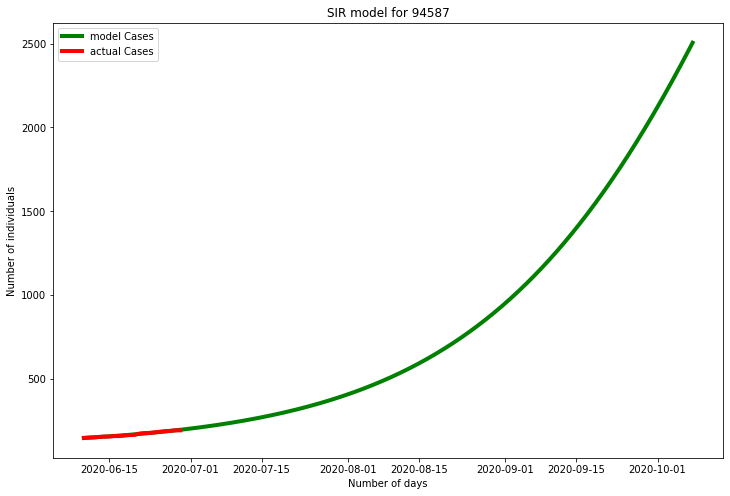

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9079.0
Fraction of infected/recovered population currently infected at start of simulation: 0.014465578493380435
Final population affected (e.g. dead) since start of simulation: 8586.67914594125
Final population affected (e.g. dead) overall: 8614.67914594125
Current and final herd immunity level: 0.0064985130520982485 0.9488966004087732
Transmissions per person per day: 0.31308251751933464
First day estimate multiplier 1.0126103275000846
R0 (initial transmit rate / recovery rate) 3.1308251751933462
R (current transmit rate / recovery rate) 3.1104794669285143
Training MSE 1.4991098446062776
Validation MSE 1.4991098446062776
Date
2020-06-03    3.110479
Name: R, dtype: float64
peak infection rate date 2020-07-25 04:48:00


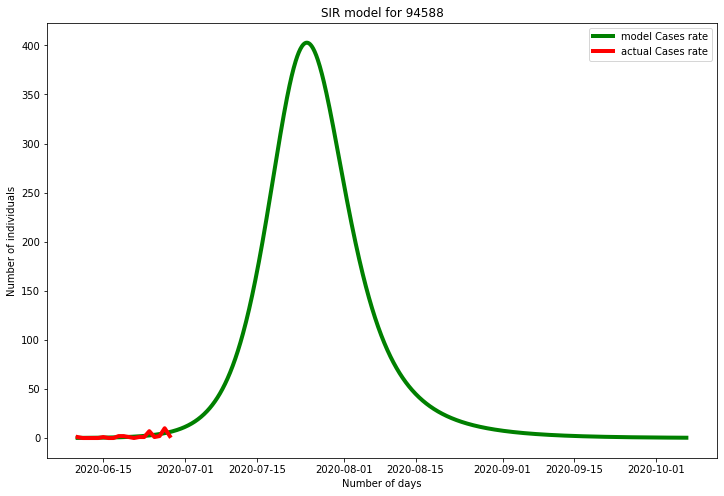

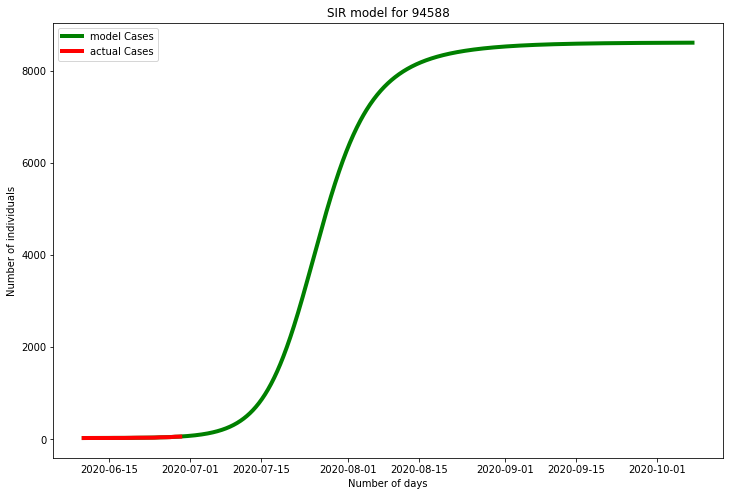

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 13074.75
Fraction of infected/recovered population currently infected at start of simulation: 0.20971698299477542
Final population affected (e.g. dead) since start of simulation: 1206.2674988475483
Final population affected (e.g. dead) overall: 1737.2674988475483
Current and final herd immunity level: 0.055297424424941205 0.13304779182183396
Transmissions per person per day: 0.10049605337547217
First day estimate multiplier 1.004329787711819
R0 (initial transmit rate / recovery rate) 1.0049605337547216
R (current transmit rate / recovery rate) 0.9493888045893712
Training MSE 51.54098045557474
Validation MSE 51.54098045557474
Date
2020-06-03    0.949389
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


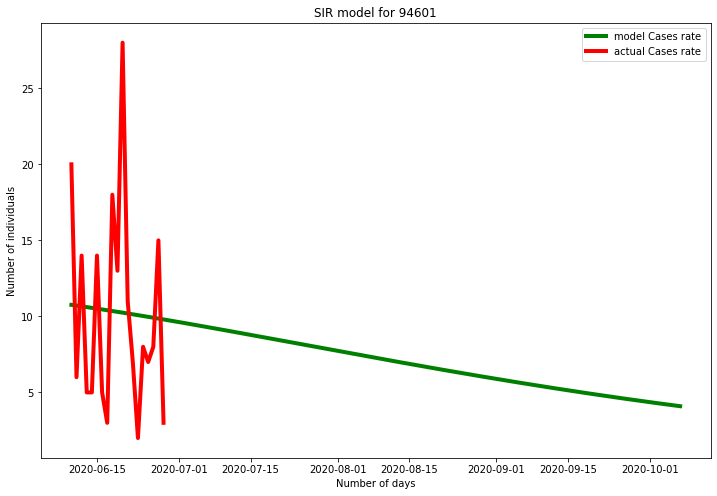

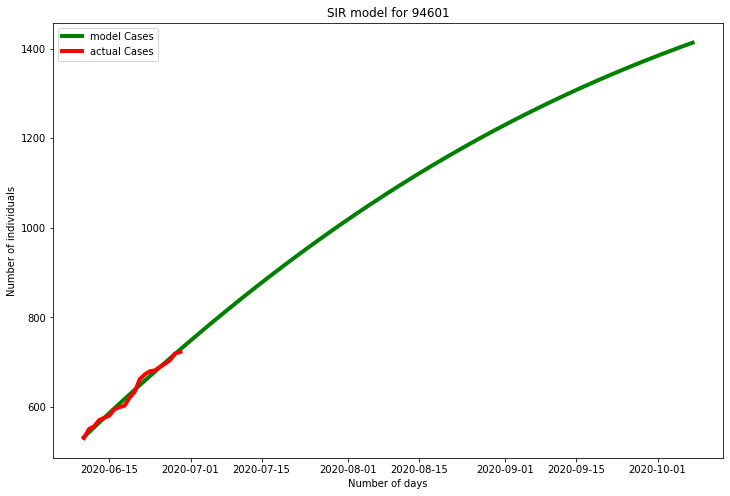

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7483.25
Fraction of infected/recovered population currently infected at start of simulation: 0.12717921662282025
Final population affected (e.g. dead) since start of simulation: 76.3820914987109
Final population affected (e.g. dead) overall: 136.3820914987109
Current and final herd immunity level: 0.009755119767480707 0.018279969648019295
Transmissions per person per day: 0.09240064634505928
First day estimate multiplier 1.0068581894971655
R0 (initial transmit rate / recovery rate) 0.9240064634505928
R (current transmit rate / recovery rate) 0.914992669733706
Training MSE 0.41602290910740625
Validation MSE 0.41602290910740625
Date
2020-06-03    0.914993
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


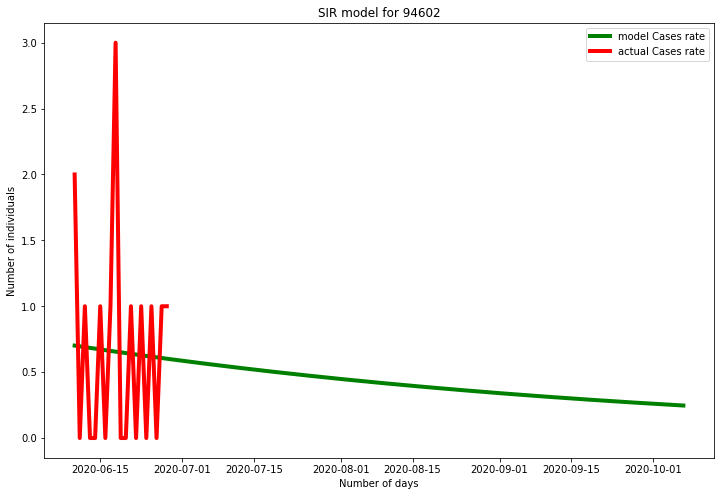

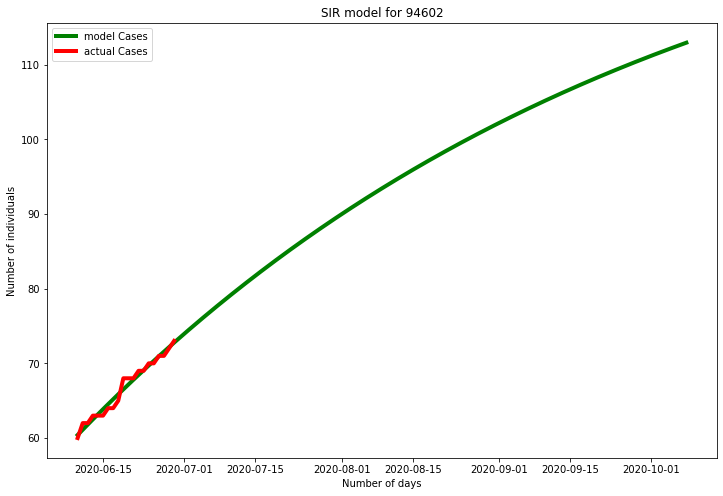

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 8648.25
Fraction of infected/recovered population currently infected at start of simulation: 0.6250996013232133
Final population affected (e.g. dead) since start of simulation: 306.5389246102759
Final population affected (e.g. dead) overall: 526.5389246102759
Current and final herd immunity level: 0.040586245772266064 0.06056605662294379
Transmissions per person per day: 0.0724072887738657
First day estimate multiplier 0.987506702632256
R0 (initial transmit rate / recovery rate) 0.724072887738657
R (current transmit rate / recovery rate) 0.6946854875598614
Training MSE 28.86800649349924
Validation MSE 28.86800649349924
Date
2020-06-03    0.694685
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


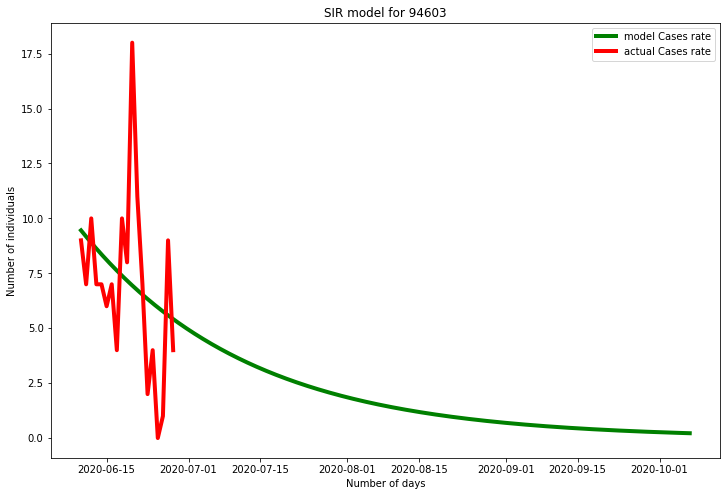

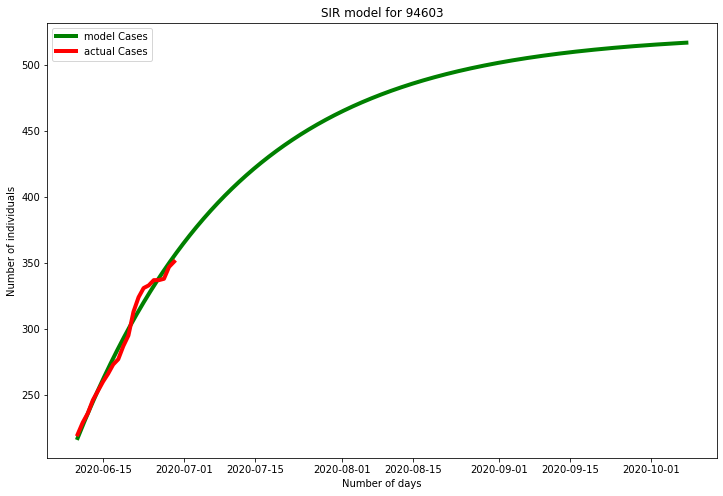

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 10778.0
Fraction of infected/recovered population currently infected at start of simulation: 0.13660056879388
Final population affected (e.g. dead) since start of simulation: 2938.3979362378614
Final population affected (e.g. dead) overall: 3089.3979362378614
Current and final herd immunity level: 0.018463536834292076 0.28644438698893815
Transmissions per person per day: 0.11880436696438683
First day estimate multiplier 0.9860905081384913
R0 (initial transmit rate / recovery rate) 1.1880436696438683
R (current transmit rate / recovery rate) 1.1661081815886514
Training MSE 17.17704710628242
Validation MSE 17.17704710628242
Date
2020-06-03    1.166108
Name: R, dtype: float64
peak infection rate date 2020-11-25 04:48:00


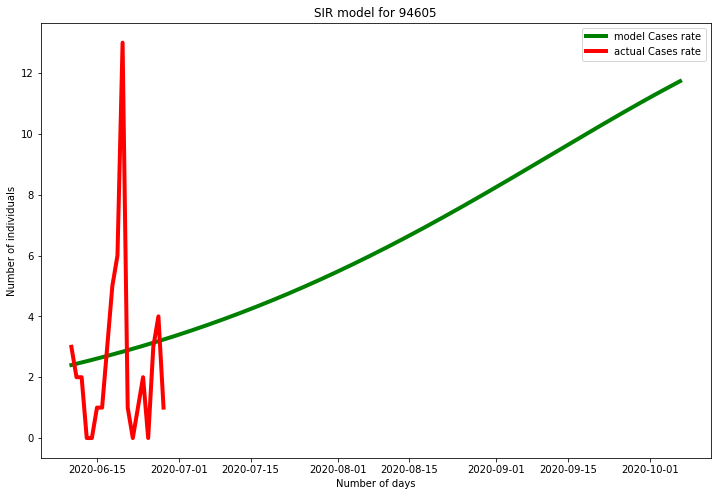

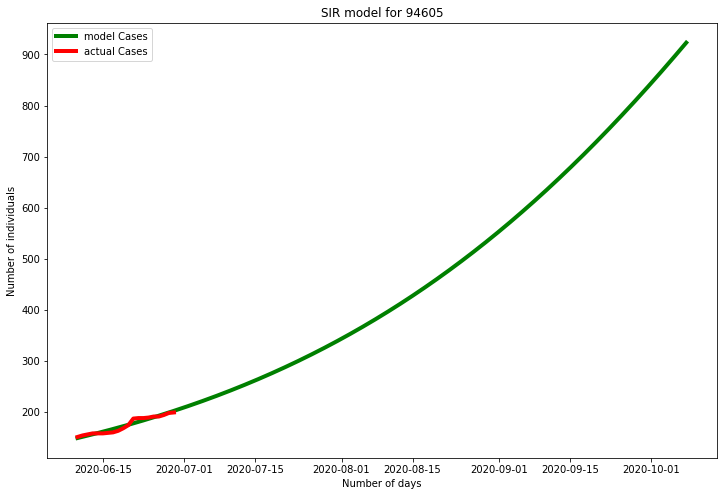

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9575.75
Fraction of infected/recovered population currently infected at start of simulation: 0.25476382111527435
Final population affected (e.g. dead) since start of simulation: 258.28907327950765
Final population affected (e.g. dead) overall: 390.28907327950765
Current and final herd immunity level: 0.018797483225856983 0.040521621686785
Transmissions per person per day: 0.09126689331239778
First day estimate multiplier 0.9828473150585146
R0 (initial transmit rate / recovery rate) 0.9126689331239778
R (current transmit rate / recovery rate) 0.895513054162819
Training MSE 2.702364905640695
Validation MSE 2.702364905640695
Date
2020-06-03    0.895513
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


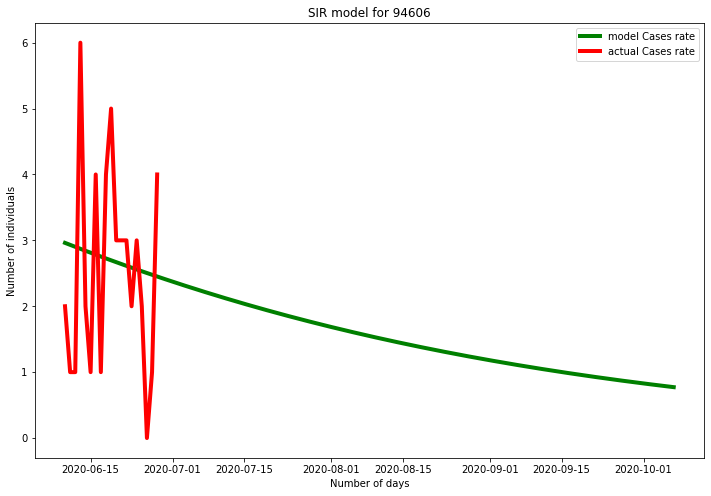

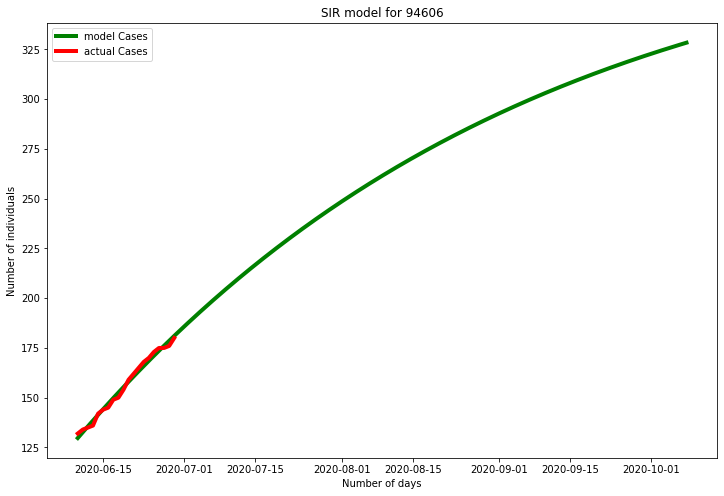

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 6563.5
Fraction of infected/recovered population currently infected at start of simulation: 0.027115951179300067
Final population affected (e.g. dead) since start of simulation: 5647.889449843826
Final population affected (e.g. dead) overall: 5708.889449843826
Current and final herd immunity level: 0.013864553972727966 0.8698087203665749
Transmissions per person per day: 0.23539102787610078
First day estimate multiplier 1.001640758724397
R0 (initial transmit rate / recovery rate) 2.353910278761008
R (current transmit rate / recovery rate) 2.321274362654167
Training MSE 1.8896177653757313
Validation MSE 1.8896177653757313
Date
2020-06-03    2.321274
Name: R, dtype: float64
peak infection rate date 2020-08-05 19:12:00


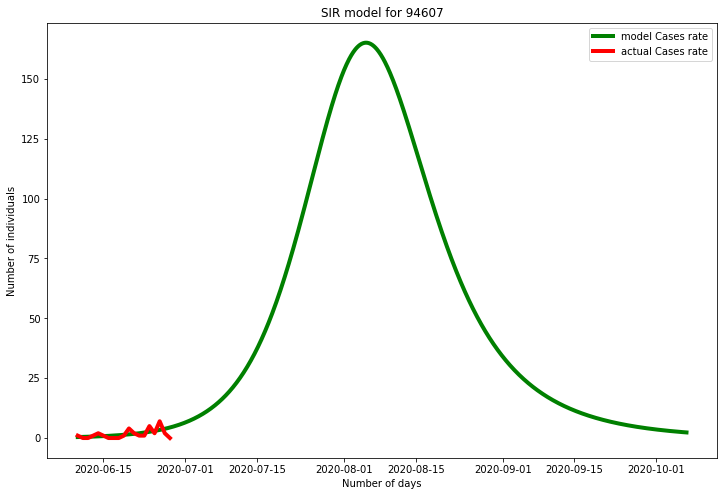

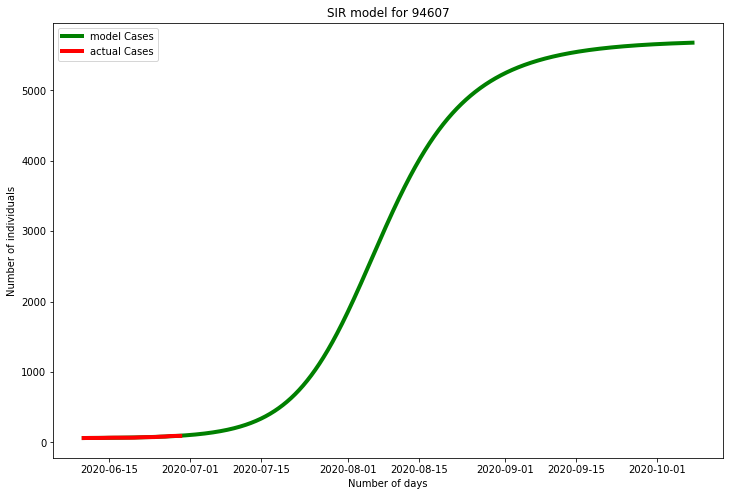

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7572.25
Fraction of infected/recovered population currently infected at start of simulation: 0.3358717038311649
Final population affected (e.g. dead) since start of simulation: 2370.8585062648863
Final population affected (e.g. dead) overall: 2410.8585062648863
Current and final herd immunity level: 0.009904585823236159 0.3183423796920861
Transmissions per person per day: 0.12068970768491007
First day estimate multiplier 0.992739458962799
R0 (initial transmit rate / recovery rate) 1.2068970768491007
R (current transmit rate / recovery rate) 1.194943261171636
Training MSE 10.73570266307724
Validation MSE 10.735702663077248
Date
2020-06-03    1.194943
Name: R, dtype: float64
peak infection rate date 2020-11-18 21:36:00


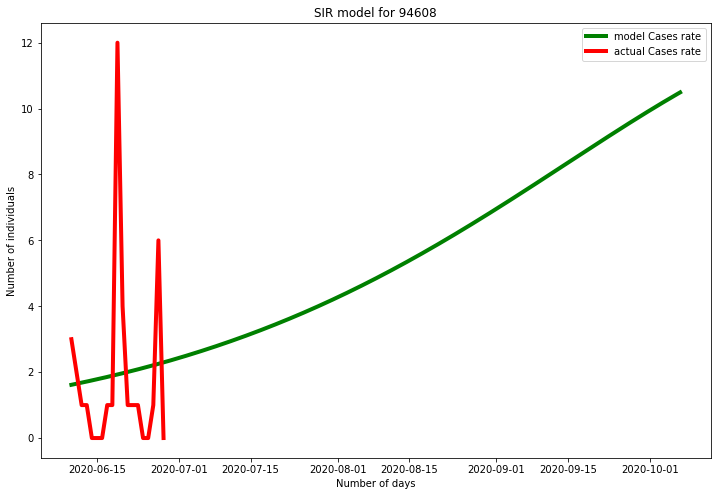

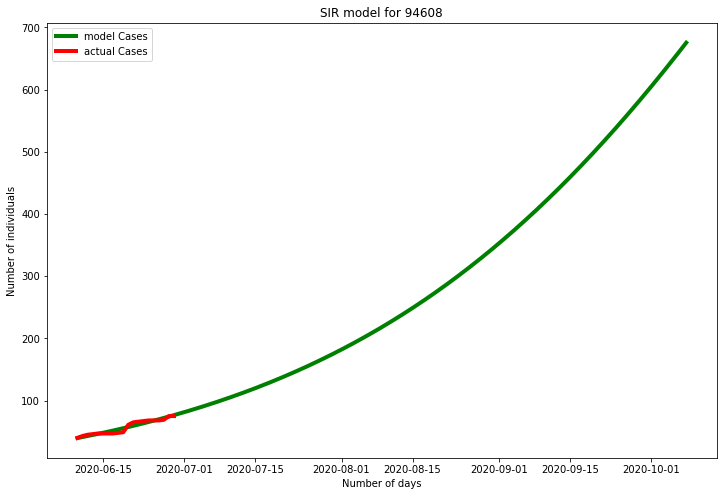

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5702.75
Fraction of infected/recovered population currently infected at start of simulation: 0.39949601262797474
Final population affected (e.g. dead) since start of simulation: 9.375246455500928
Final population affected (e.g. dead) overall: 22.37524645550093
Current and final herd immunity level: 0.003331725921704441 0.0039623798356134094
Transmissions per person per day: 0.06416546649560588
First day estimate multiplier 1.0170165501572173
R0 (initial transmit rate / recovery rate) 0.6416546649560588
R (current transmit rate / recovery rate) 0.6395168474760422
Training MSE 0.27182458007266125
Validation MSE 0.27182458007266125
Date
2020-06-03    0.639517
Name: R, dtype: float64
peak infection rate date 2020-06-10 00:00:00


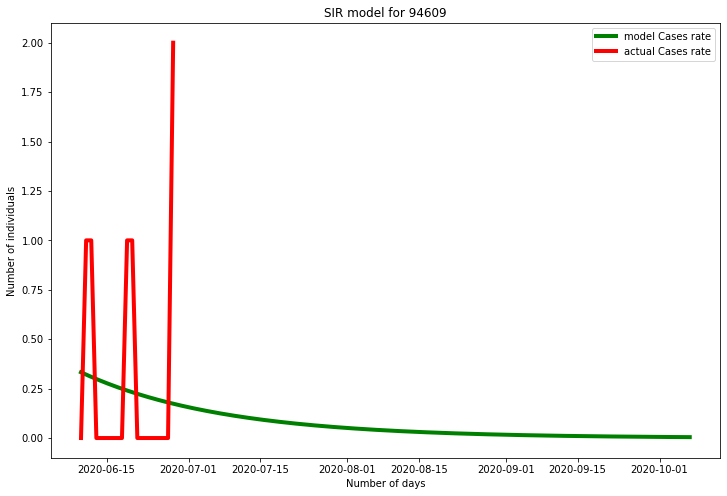

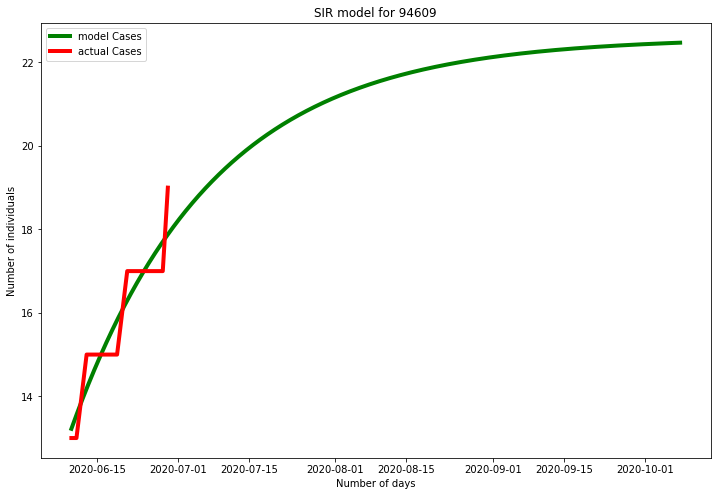

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7874.0
Fraction of infected/recovered population currently infected at start of simulation: 0.12088101058312856
Final population affected (e.g. dead) since start of simulation: 1699.49357863369
Final population affected (e.g. dead) overall: 1732.49357863369
Current and final herd immunity level: 0.005207010414020828 0.2199059991444993
Transmissions per person per day: 0.11662970837530721
First day estimate multiplier 0.9710987463665958
R0 (initial transmit rate / recovery rate) 1.1662970837530722
R (current transmit rate / recovery rate) 1.1602241626921277
Training MSE 0.6825902927454168
Validation MSE 0.6825902927454168
Date
2020-06-03    1.160224
Name: R, dtype: float64
peak infection rate date 2021-02-27 04:48:00


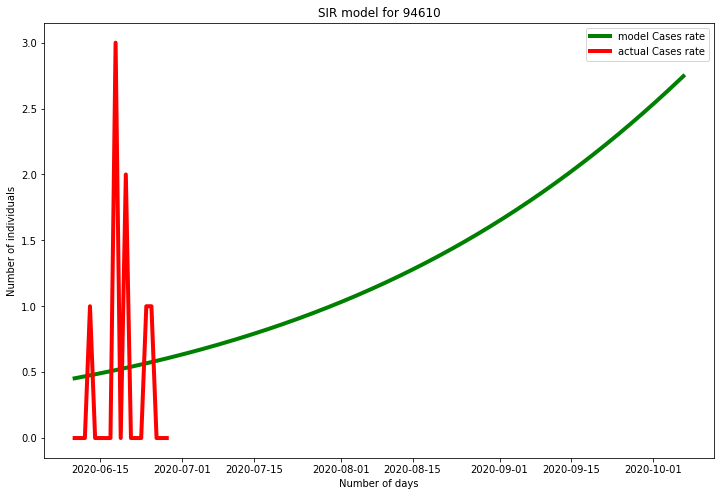

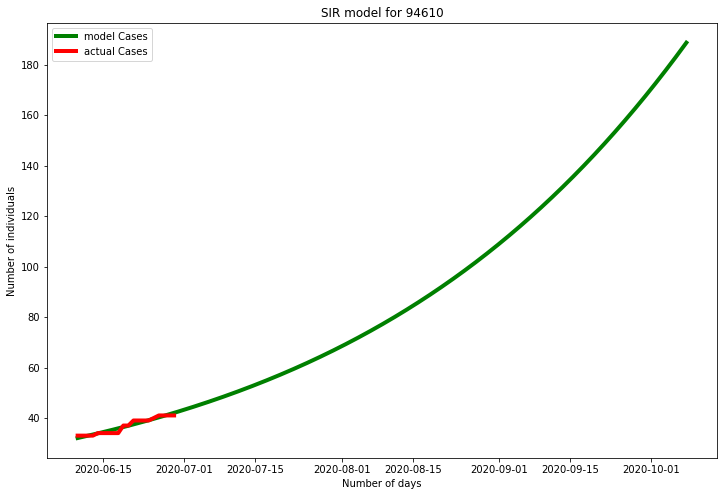

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 9846.0
Fraction of infected/recovered population currently infected at start of simulation: 0.020773169561998817
Final population affected (e.g. dead) since start of simulation: 6089.550942910566
Final population affected (e.g. dead) overall: 6140.550942910566
Current and final herd immunity level: 0.00578915295551493 0.6236654841236401
Transmissions per person per day: 0.15709273894791315
First day estimate multiplier 1.00116497589793
R0 (initial transmit rate / recovery rate) 1.5709273894791314
R (current transmit rate / recovery rate) 1.561833050539429
Training MSE 0.276636328130105
Validation MSE 0.276636328130105
Date
2020-06-03    1.561833
Name: R, dtype: float64
peak infection rate date 2020-10-23 16:48:00


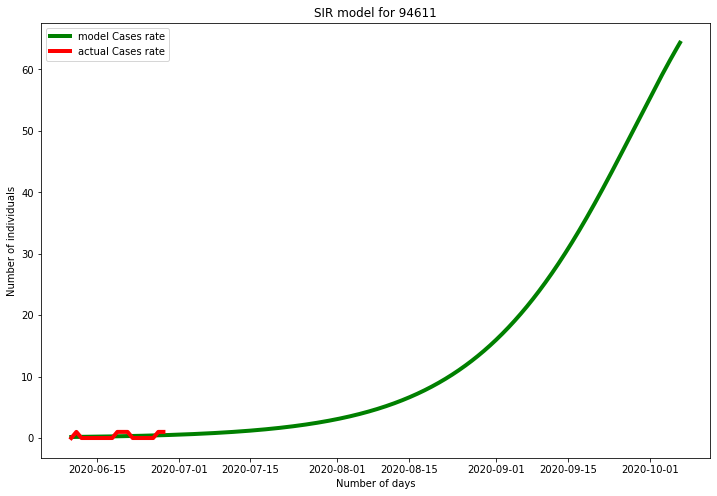

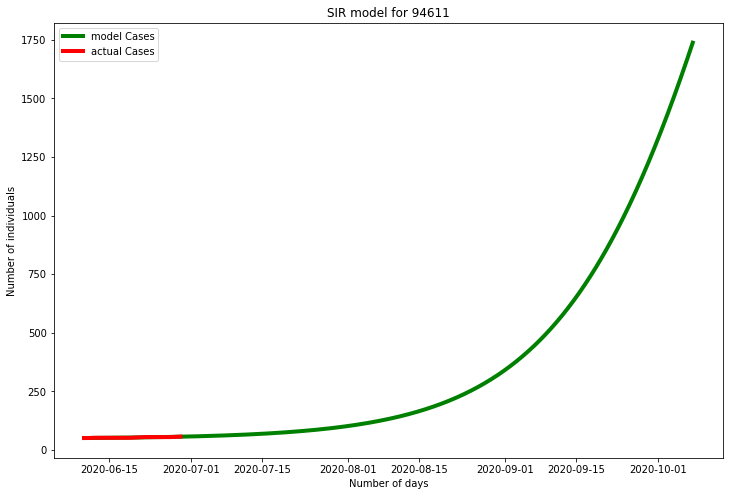

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 4015.5
Fraction of infected/recovered population currently infected at start of simulation: 0.03262521374283742
Final population affected (e.g. dead) since start of simulation: 3070.1565410674716
Final population affected (e.g. dead) overall: 3094.1565410674716
Current and final herd immunity level: 0.007720084671896402 0.7704822338931575
Transmissions per person per day: 0.19150662460647863
First day estimate multiplier 0.988119547104269
R0 (initial transmit rate / recovery rate) 1.9150662460647863
R (current transmit rate / recovery rate) 1.9002817724928753
Training MSE 0.19061967852089684
Validation MSE 0.19061967852089684
Date
2020-06-03    1.900282
Name: R, dtype: float64
peak infection rate date 2020-09-01 07:12:00


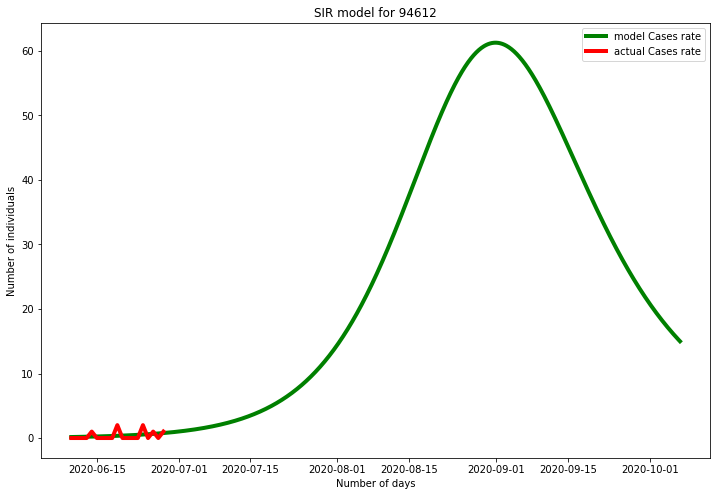

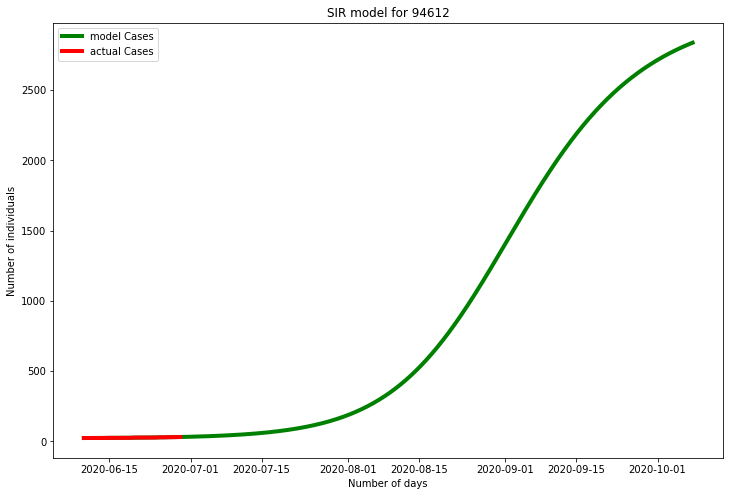

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 6077.0
Fraction of infected/recovered population currently infected at start of simulation: 0.061084608340962916
Final population affected (e.g. dead) since start of simulation: 2292.7277921640807
Final population affected (e.g. dead) overall: 2433.7277921640807
Current and final herd immunity level: 0.02698700016455488 0.4004012457779371
Transmissions per person per day: 0.12916634661461657
First day estimate multiplier 0.9965289250244191
R0 (initial transmit rate / recovery rate) 1.2916634661461657
R (current transmit rate / recovery rate) 1.2568053439727296
Training MSE 5.286603507313864
Validation MSE 5.286603507313864
Date
2020-06-03    1.256805
Name: R, dtype: float64
peak infection rate date 2020-11-06 12:00:00


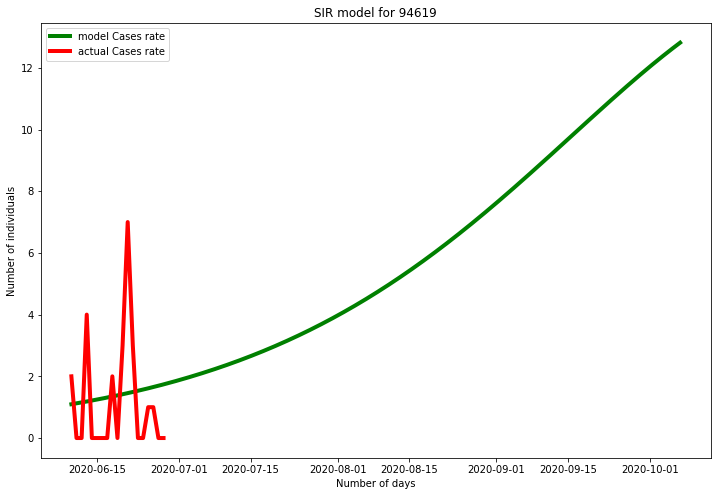

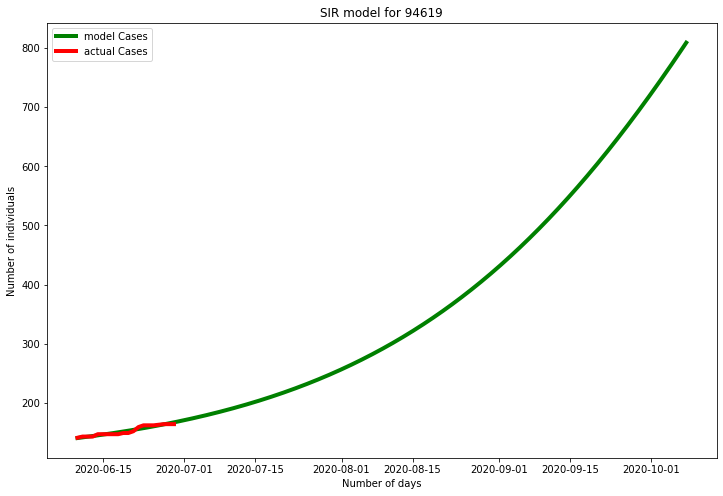

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 8821.75
Fraction of infected/recovered population currently infected at start of simulation: 0.21348141246717464
Final population affected (e.g. dead) since start of simulation: 1694.0775445643922
Final population affected (e.g. dead) overall: 1952.0775445643922
Current and final herd immunity level: 0.042168503981636296 0.2211502433594359
Transmissions per person per day: 0.11162099275818997
First day estimate multiplier 0.9955605224484918
R0 (initial transmit rate / recovery rate) 1.1162099275818997
R (current transmit rate / recovery rate) 1.0691410248063205
Training MSE 14.841955974702154
Validation MSE 14.841955974702154
Date
2020-06-03    1.069141
Name: R, dtype: float64
peak infection rate date 2020-08-28 00:00:00


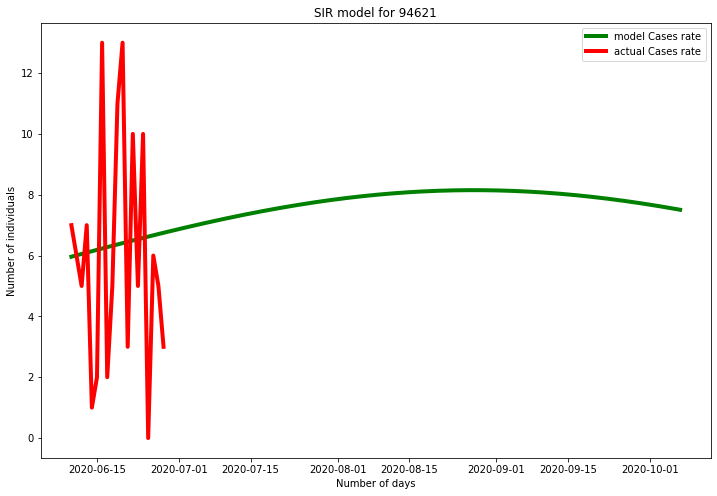

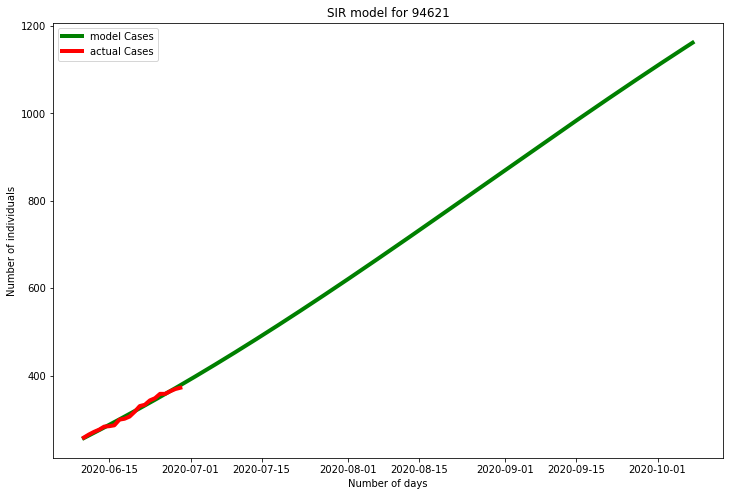

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 4273.0
Fraction of infected/recovered population currently infected at start of simulation: 0.09175094164390679
Final population affected (e.g. dead) since start of simulation: 684.8825359867656
Final population affected (e.g. dead) overall: 710.8825359867656
Current and final herd immunity level: 0.007488883688275216 0.16650597578004464
Transmissions per person per day: 0.11372459617858821
First day estimate multiplier 1.0229807123602082
R0 (initial transmit rate / recovery rate) 1.137245961785882
R (current transmit rate / recovery rate) 1.128729259053107
Training MSE 0.3062502163976843
Validation MSE 0.3062502163976843
Date
2020-06-03    1.128729
Name: R, dtype: float64
peak infection rate date 2021-03-19 19:12:00


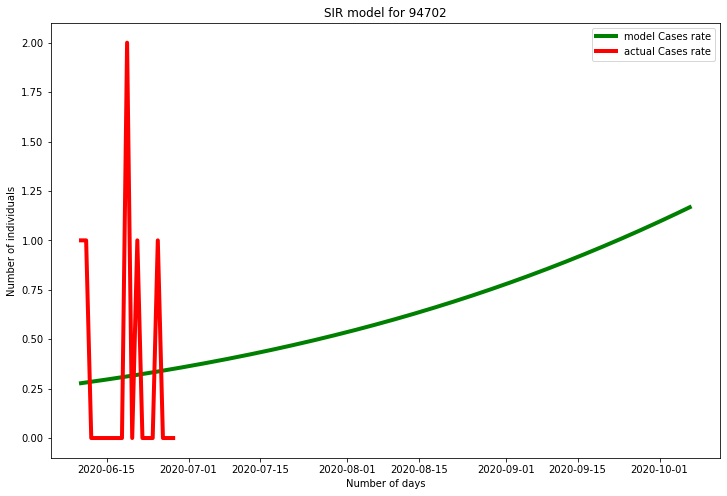

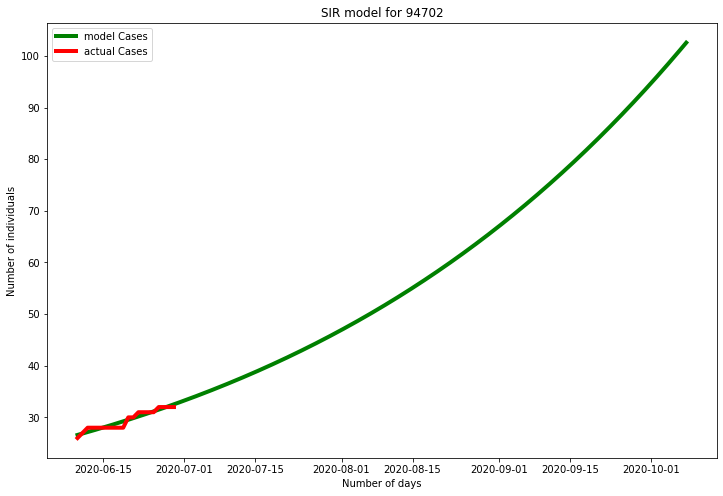

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 5484.25
Fraction of infected/recovered population currently infected at start of simulation: 0.030334436680572056
Final population affected (e.g. dead) since start of simulation: 3825.6679734018594
Final population affected (e.g. dead) overall: 3865.6679734018594
Current and final herd immunity level: 0.00856999589734239 0.7047406177664614
Transmissions per person per day: 0.17368874664005943
First day estimate multiplier 0.9826439895963875
R0 (initial transmit rate / recovery rate) 1.7368874664005942
R (current transmit rate / recovery rate) 1.7220023479393956
Training MSE 0.7556106456621027
Validation MSE 0.7556106456621027
Date
2020-06-03    1.722002
Name: R, dtype: float64
peak infection rate date 2020-09-17 07:12:00


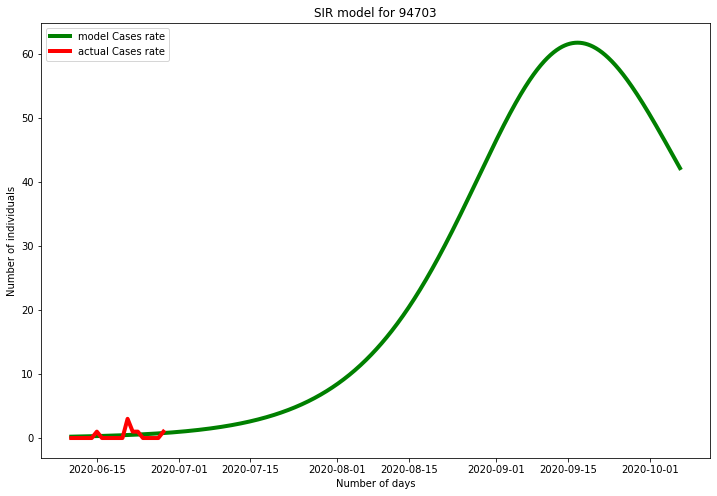

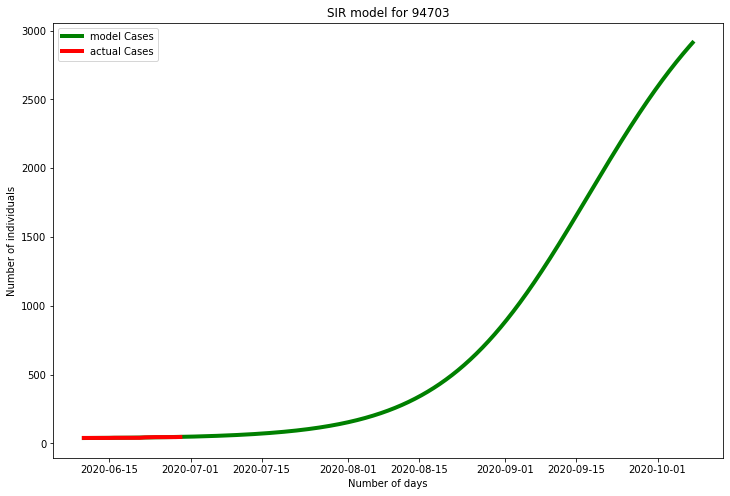

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 7297.5
Fraction of infected/recovered population currently infected at start of simulation: 0.11939641237292123
Final population affected (e.g. dead) since start of simulation: 5404.035825306625
Final population affected (e.g. dead) overall: 5417.035825306625
Current and final herd immunity level: 0.0031517643028434396 0.7421782239087921
Transmissions per person per day: 0.18263575192128997
First day estimate multiplier 0.9238279744449609
R0 (initial transmit rate / recovery rate) 1.8263575192128998
R (current transmit rate / recovery rate) 1.8206012707796149
Training MSE 0.6320772242067306
Validation MSE 0.6320772242067306
Date
2020-06-03    1.820601
Name: R, dtype: float64
peak infection rate date 2020-09-08 04:48:00


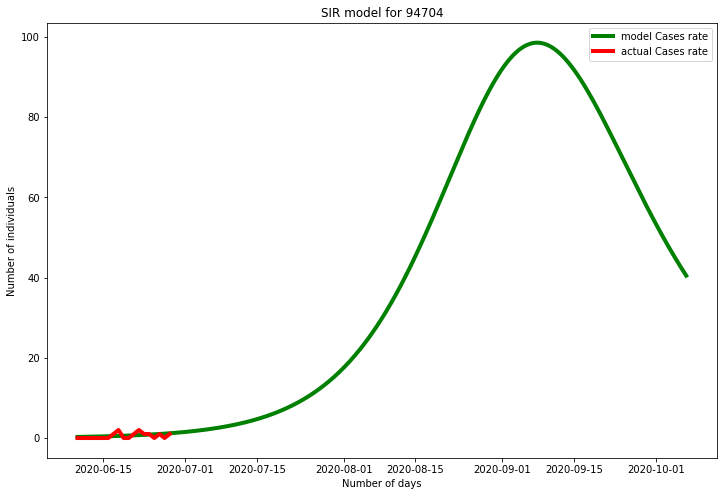

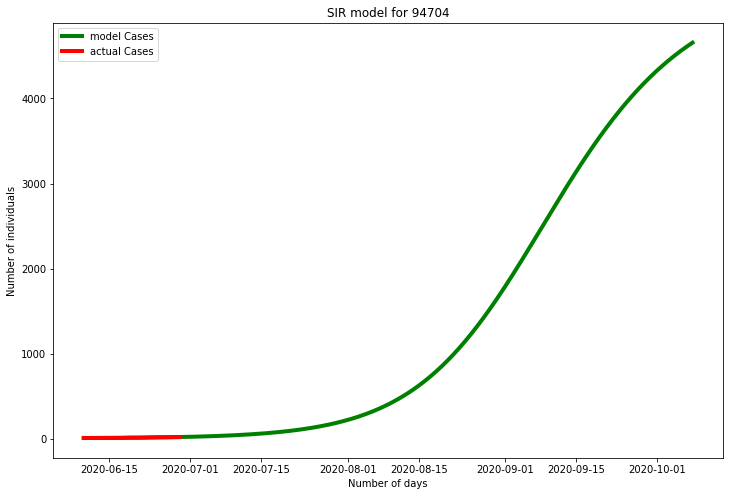

Population fraction susceptible (e.g. would die if infected): 0.25
Population susceptible (e.g. would die if infected): 1865.25
Fraction of infected/recovered population currently infected at start of simulation: 0.029448021350903946
Final population affected (e.g. dead) since start of simulation: 1513.8224651269627
Final population affected (e.g. dead) overall: 1526.8224651269627
Current and final herd immunity level: 0.009650180940892641 0.818460782279776
Transmissions per person per day: 0.20909702248530815
First day estimate multiplier 0.9855006938761315
R0 (initial transmit rate / recovery rate) 2.0909702248530815
R (current transmit rate / recovery rate) 2.07079198384123
Training MSE 0.08555867015329414
Validation MSE 0.08555867015329414
Date
2020-06-03    2.070792
Name: R, dtype: float64
peak infection rate date 2020-08-19 21:36:00


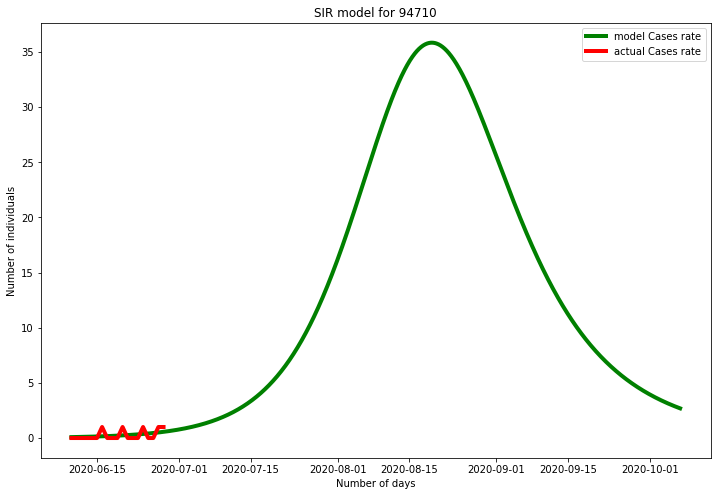

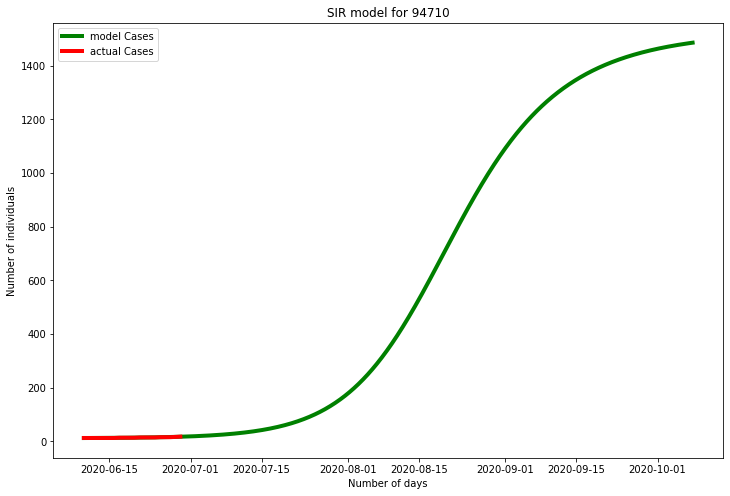

In [68]:
SAMPLING_RATE = 10
SIMULATION_DAYS = 360
VISUALIZATION_DAYS = 120
METRIC = 'Cases'
locations_with_cases['R'] = 0.0
locations_with_cases['Final cases'] = 0.0
locations_with_cases['MSE'] = 0.0

for area in locations_with_cases['Location'].unique():
    area_df = alameda_df[alameda_df['Location'] == str(area)]
    population = pop_df[pop_df.index == str(area)]['population'].iloc[0]
    # Calculate R for zip code or region

    train_area_df = area_df[
        (area_df[METRIC] > 0)
        & (area_df.index >= '2020-06-10')
    ]

    train_data = dataproc.convert_data_to_numpy(train_area_df, METRIC, smooth=False)


    # Reasonable search regions for each parameter
    pop_frac = 0.25
    recovery_days = 10.0 # This is fairly constant
    infection_rate_range = [0.001, 0.80]
    multiplier_range = [0.01, 10.0]
    frac_infected_range = [0.01, 0.99]

    best_param, best_value = optimizer.minimize(
        train_data, population, recovery_days,
        pop_frac, infection_rate_range, multiplier_range, frac_infected_range
    )

    #Validation plot
    validation_area_df = train_area_df

    best_infection_rate = best_param[0]
    best_multiplier = best_param[1]
    best_frac_infected = best_param[2]

    infected = train_data[0] * best_multiplier * best_frac_infected
    recovered = train_data[0] * best_multiplier * (1 - best_frac_infected)
    t, s, i, r = sir_model.compute_sir(
        SAMPLING_RATE,
        SIMULATION_DAYS,
        population * pop_frac,
        infected,
        recovered,
        best_infection_rate,
        recovery_days
    )

    valid_obj = sir_model.create_objective_fn(
        validation_area_df[METRIC].to_numpy(), population, sampling_rate=SAMPLING_RATE)

    validation_mse = valid_obj(pop_frac, best_infection_rate, recovery_days, best_multiplier, best_frac_infected)

    print('Population fraction susceptible (e.g. would die if infected):', pop_frac)
    print('Population susceptible (e.g. would die if infected):', pop_frac * population)
    print('Fraction of infected/recovered population currently infected at start of simulation:', best_frac_infected)
    print('Final population affected (e.g. dead) since start of simulation:', (s[0] - s[-1]))
    print('Final population affected (e.g. dead) overall:', (train_area_df[METRIC].iloc[0] + s[0] - s[-1]))
    print('Current and final herd immunity level:',
          train_data[-1] / pop_frac / population,
          (population * pop_frac - s[-1]) / pop_frac / population)
    print('Transmissions per person per day:', best_infection_rate)
    print('First day estimate multiplier', best_multiplier)
    print('R0 (initial transmit rate / recovery rate)', best_infection_rate * recovery_days)
    print('R (current transmit rate / recovery rate)', best_infection_rate * recovery_days * (1 - train_data[-1] / pop_frac / population))
    locations_with_cases.loc[locations_with_cases['Location'] == str(area), 'R'] = best_infection_rate * recovery_days * (1 - train_data[-1] / pop_frac / population)
    locations_with_cases.loc[locations_with_cases['Location'] == str(area), 'Final cases'] = (train_area_df[METRIC].iloc[0] + s[0] - s[-1])
    locations_with_cases.loc[locations_with_cases['Location'] == str(area), 'MSE'] = best_value
    
    print('Training MSE', best_value)
    print('Validation MSE', validation_mse)
    print(locations_with_cases[locations_with_cases['Location'] == str(area)]['R'])
    plot_sir_model(r, i, s, SIMULATION_DAYS, VISUALIZATION_DAYS, validation_area_df, METRIC, SAMPLING_RATE, area)

zip 94501, case density 0.0012888760597984789, increase % [45.45454545]
zip 94502, case density 7.817615041091338e-05, increase % [inf]
zip 94536, case density 0.0011683124268595801, increase % [13.53383459]
zip 94538, case density 0.001216501634936249, increase % [27.19298246]
zip 94539, case density 0.0003679514304111857, increase % [-37.03703704]
zip 94541, case density 0.005735393345905638, increase % [16.72535211]
zip 94542, case density 0.0016479265265929117, increase % [156.25]
zip 94544, case density 0.006937771006679948, increase % [13.44339623]
zip 94545, case density 0.002529922037992753, increase % [33.33333333]
zip 94546, case density 0.0032397129433631056, increase % [41.01123596]
zip 94550, case density 0.003926449787835926, increase % [118.23899371]
zip 94551, case density 0.0033471653693278505, increase % [114.4]
zip 94552, case density 0.0001483074413258685, increase % [-82.60869565]
zip 94555, case density 0.0005209961446285298, increase % [150.]
zip 94560, case dens

/Users/bfoo/env3/general/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


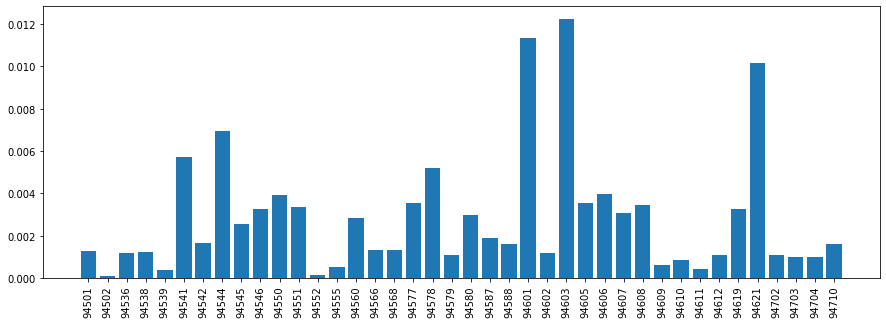

In [88]:
plot_area = []
plot_frac_cases = []

date_offset = -1

for area in locations_with_cases['Location'].unique():
    area_df = alameda_df[alameda_df['Location'] == str(area)]
    population = pop_df[pop_df.index == str(area)]['population'].iloc[0]
    plot_area.append(area)
    risk = np.mean(
        area_df['Cases'].iloc[date_offset-7:date_offset].to_numpy()
        - area_df['Cases'].iloc[date_offset-21:date_offset-14].to_numpy()
    ) * 4 / population
    risk_last_week = np.mean(
        area_df['Cases'].iloc[date_offset-14:date_offset-7].to_numpy()
        - area_df['Cases'].iloc[date_offset-28:date_offset-21].to_numpy()
    ) * 4 / population,    
    plot_frac_cases.append(risk)
    print('zip {}, case density {}, increase % {}'.format(
        area,
        risk,
        (risk - risk_last_week) / risk_last_week * 100,    
    ))
    
plt.figure(figsize=(15,5))
plt.bar(plot_area, plot_frac_cases)
plt.xticks(rotation=90)
plt.show()

In [49]:
# Derived metrics
locations_with_cases['Final frac cases'] = locations_with_cases['Final cases'] / locations_with_cases['population']
locations_with_cases['Bart stops'] = locations_with_cases['Bart entries'] + locations_with_cases['Bart exits']


In [50]:
# Demographics
demographics_df = pd.read_csv('data_repo/alameda_demographics/demographics_by_zip_code.csv')
demographics_df['Location'] = demographics_df['Location'].astype(str)
demographics_df = demographics_df.set_index('Location')
demographics_df['Fraction of population that is Black or Other'] = (
    demographics_df['Fraction of population that is Black']
    + demographics_df['Fraction of population that is Other']
)
demographics_df['Fraction of population that is Asian or White'] = (
    demographics_df['Fraction of population that is Asian']
    + demographics_df['Fraction of population that is White']
)

demographics_df['Fraction of population that is Non-Asian and Non-White'] = (
    1 - demographics_df['Fraction of population that is Asian or White']
)

demographics_df['Fraction of Non-Asian population that is Non-White'] = (
    (1 - demographics_df['Fraction of population that is Asian']
     - demographics_df['Fraction of population that is White']) /
    (1 - demographics_df['Fraction of population that is Asian'])
)
demographics_df['Fraction non-white collar'] = 1 - demographics_df['White collar fraction']

In [51]:
# Join with locations
locations_with_cases = locations_with_cases.join(demographics_df, on='Location', how='left')

In [52]:
# Save the dataframe for later!
locations_with_cases.to_pickle('data/alameda_cases.pkl')

In [53]:
# Load the dataframe for visualizations
locations_with_cases = pd.read_pickle('data/alameda_cases.pkl')

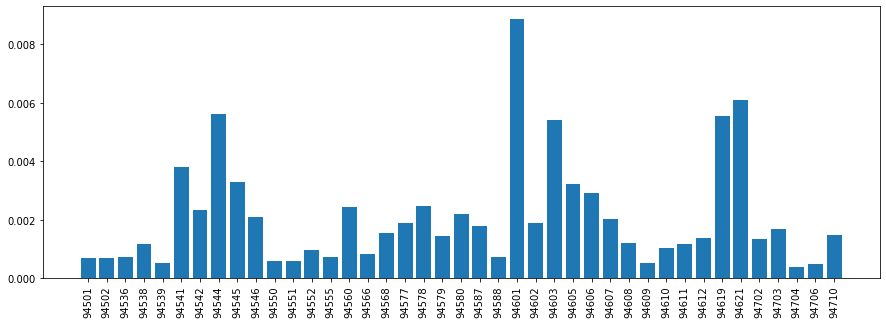

In [54]:
plt.figure(figsize=(15,5))
plt.bar(locations_with_cases['Location'], locations_with_cases['Frac Cases'])
plt.xticks(rotation=90)
plt.show()


In [55]:
def poly_line(x, coef):
    y = np.zeros_like(x, dtype=np.float64)
    for p in range(len(coef)):
        y += np.power(x, p) * coef[-(p + 1)]
    return y

In [56]:
# Function to plot trend line
def power_law_plot(df, x_col, y_col, x_log_scale=True, y_log_scale=True, save_fig_path=''):
    df = df[~df[x_col].isna()]
    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()
    log_x = np.log(x)
    log_y = np.log(y)
    coef = np.polyfit(log_x, log_y, w=y + 25, deg=1)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(df[x_col],
               df[y_col],
               label='data')
    trend_line_x = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(trend_line_x, np.exp(poly_line(np.log(trend_line_x), coef)), label='fitted line', linewidth=4)

    texts = zip(df[x_col].tolist(),
                df[y_col].tolist(),
                (df['city'] + ', ' + df['Location']).tolist())
    texts = [plt.text(x, y, t) for (x, y, t) in texts]

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if x_log_scale:
        ax.set_xscale('log')
    if y_log_scale:
        ax.set_yscale('log')
    formatter = ScalarFormatter()
    formatter = FormatStrFormatter('%.2g')
#    formatter.set_scientific(True)
#     formatter.set_powerlimits((-1, 1))
    ax.get_xaxis().set_minor_formatter(formatter)
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_minor_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    plt.xticks(rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    #ax.get_xaxis().set_minor_formatter(ax.get_xaxis().get_major_formatter())

#    ax.get_yaxis().get_major_formatter().labelOnlyBase = False
    #adjust_text(texts, autoalign='', only_move={'points':'y', 'text':'y'})#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    #plt.loglog()
#    ax.locator_params(tight=True, nbins=10)
#     ax.locator_params(axis='x', nbins=10)
#     ax.locator_params(axis='y', nbins=10)
#     ax.set_xticks(np.exp(np.linspace(np.log(x_range[0]), np.log(x_range[-1]), 10)))
#     ax.xaxis.set_major_formatter(ScalarFormatter())
#     ax.set_yticks(np.exp(np.linspace(np.log(np.min(y)), np.log(np.max(y)), 10)))
#     ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.legend()
    ax.set_title(x_col + ' vs ' + y_col + ' (power {:.2f}, pearson corr {:.2f}, p-value {:.2f})'.format(
        coef[0], *pearsonr(x, y)))
    plt.show()
    if save_fig_path:
        plt.savefig(os.path.join(save_fig_path, x_col + ' vs ' + y_col))
        
    return ax

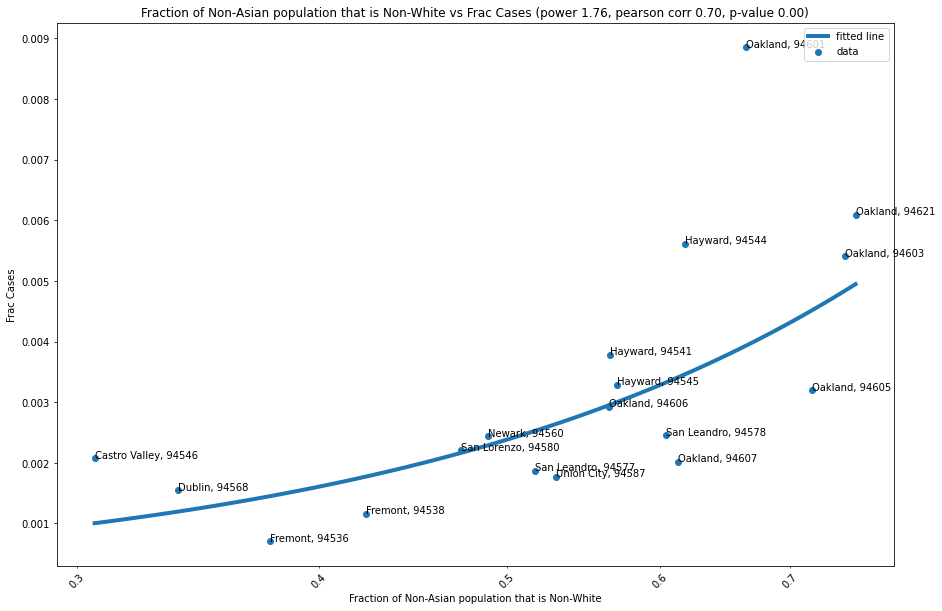

<Figure size 432x288 with 0 Axes>

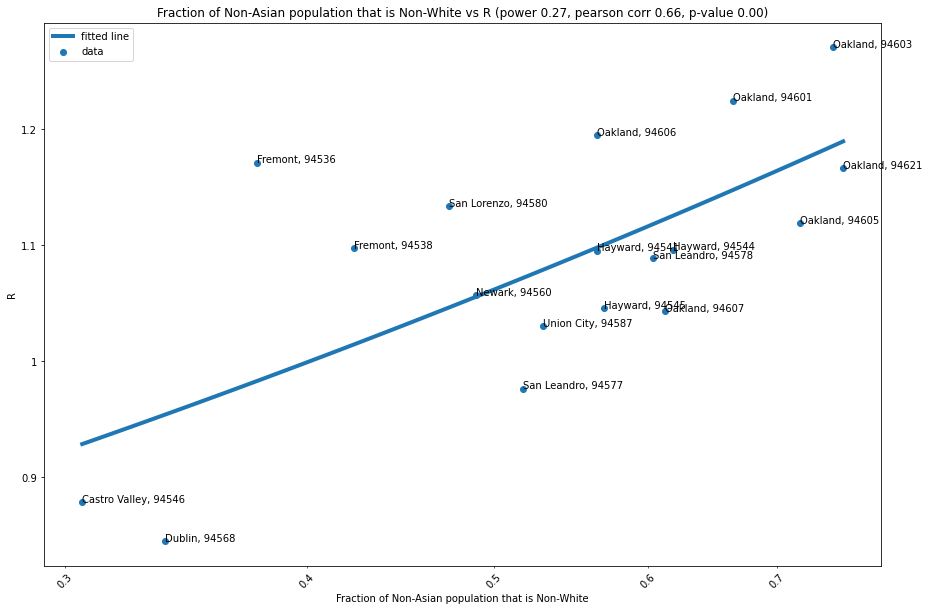

<Figure size 432x288 with 0 Axes>

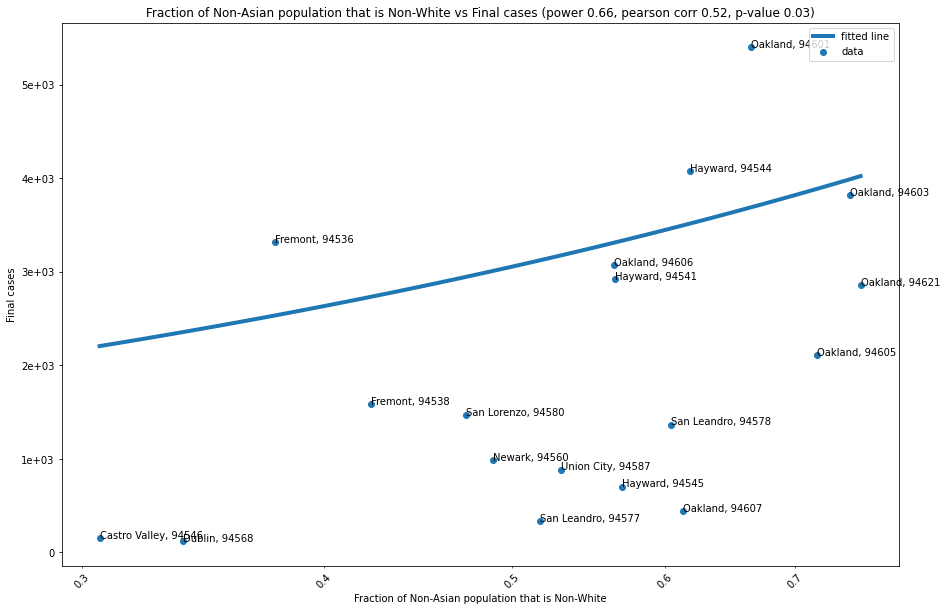

<Figure size 432x288 with 0 Axes>

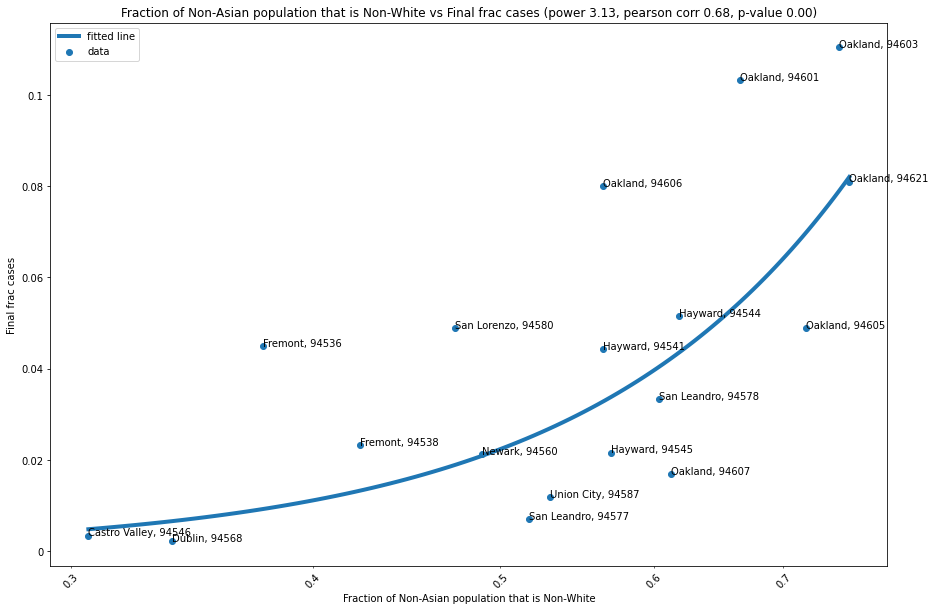

<Figure size 432x288 with 0 Axes>

In [30]:
save_fig_path = 'data/images/alameda'

fit_locations = locations_with_cases[
    (locations_with_cases['Cases'] >= 50)
    & (~locations_with_cases['Location'].isin(['94619', '94704', '94611', '94602']))]

for x_col in ['Fraction of Non-Asian population that is Non-White',]:
    for y_col in ['Frac Cases', 'R', 'Final cases', 'Final frac cases']:
        power_law_plot(fit_locations,
                       x_col, y_col,
                       y_log_scale=False,
                       save_fig_path=save_fig_path,
                      )

In [34]:
# Function to plot trend line
def animated_power_law_plot(df, x_col, y_col, x_log_scale=True, y_log_scale=True, save_fig_path=''):
    df = df[~df[x_col].isna()]
    dates_list = sorted(df.index.unique())
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_xlim(df[x_col].min() * 0.9, df[x_col].max() * 1.1)
    ax.set_ylim(df[y_col].min() * 1.0, df[y_col].max() * 1.0)
    if x_log_scale:
        ax.set_xscale('log')
    if y_log_scale:
        ax.set_yscale('log')
    formatter = ScalarFormatter()
    formatter = FormatStrFormatter('%.2g')
    ax.get_xaxis().set_minor_formatter(formatter)
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_minor_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    plt.xticks(rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    ax.legend()

    date_df = df[df.index==dates_list[0]]
    x = date_df[x_col].to_numpy()
    y = date_df[y_col].to_numpy()
    log_x = np.log(x)
    log_y = np.log(y)
    coef = np.polyfit(log_x, log_y, w=y, deg=1)   
    trend_line_x = np.linspace(np.min(x), np.max(x), 100)
    plt_line, = ax.plot(trend_line_x, np.exp(poly_line(np.log(trend_line_x), coef)), label='fitted line', linewidth=4)
    plt_points = ax.scatter(date_df[x_col],
               date_df[y_col],
               label='data')     
    all_locations = df['Location'].unique().tolist()
    location_to_label = {}
    for location in all_locations:
        location_df = df[df['Location'] == location]
        label = location_df['city'] + ', ' + location_df['Location']
        label = ax.annotate(label[0], xy=(0.001, 0.001))
        location_to_label[location] = label
        
    text_coords = zip(date_df[x_col].tolist(),
                      date_df[y_col].tolist())
    plt_title = ax.set_title('{}: (power {:.2f}, pearson corr {:.2f}, p-value {:.2f})'.format(
        dates_list[0].strftime('%b %d, %Y'), coef[0], *pearsonr(log_x, log_y)))   
    
    def init():
        #plt_points, plt_line = plot_date(dates_list[0], plt_points, plt_line)
        return (plt_line, plt_points, plt_title) + tuple(location_to_label.values())
    
    def animate(i):
        date_df = df[df.index==dates_list[i]]
        locations = date_df['Location'].to_numpy()
        x = date_df[x_col].to_numpy()
        y = date_df[y_col].to_numpy()
        log_x = np.log(x)
        log_y = np.log(y)
        coef = np.polyfit(log_x, log_y, w=y + 25, deg=1)   
        trend_line_x = np.linspace(np.min(x), np.max(x), 100)
        plt_line.set_data(trend_line_x, np.exp(poly_line(np.log(trend_line_x), coef)))
        plt_points.set_offsets(np.transpose(np.array([date_df[x_col].to_numpy(), date_df[y_col].to_numpy()])))   
#         plt_title.set_text('{}: (power {:.2f}, pearson corr {:.2f}, p-value {:.2f})'.format(
#             dates_list[i].strftime('%b %d, %Y'), coef[0], *pearsonr(log_x, log_y)))
        plt_title.set_text('{}: Inequality: {:.2f}x higher cases'.format(
            dates_list[i].strftime('%b %d, %Y'), np.power(6, coef[0])))
        for label in location_to_label.values():
            label.set_position((0.001, 0.001))
            label.xy = (0.001, 0.001)            
        for j in range(locations.shape[0]):
            label = location_to_label[locations[j]]
            label.set_position((x[j], y[j]))
            label.xy = (x[j], y[j])
        return (plt_line, plt_points, plt_title) + tuple(location_to_label.values())

    ani = animation.FuncAnimation(
        fig, animate, frames=len(dates_list), init_func=init, interval=250, blit=True, save_count=len(dates_list))    
    HTML(ani.to_html5_video())
    if save_fig_path:
        ani.save('data/images/{} vs {}.mp4'.format(x_col, y_col))
        
    return ax

In [35]:
# Get the comprehensive dataframe with only positive cases and zip codes
MIN_CASES = 25
MIN_ZIP_CODES = 10

pos_zip_alameda_df = alameda_df[
    (alameda_df['Cases'] >= MIN_CASES)
    & (alameda_df['Location'].str.contains('9'))
]
num_zips_by_date = pos_zip_alameda_df.groupby(pos_zip_alameda_df.index).count()['Location']
min_date = num_zips_by_date[num_zips_by_date >= MIN_ZIP_CODES].index[0]

pos_zip_alameda_df = pos_zip_alameda_df[pos_zip_alameda_df.index >= min_date]
pos_zip_alameda_df = pos_zip_alameda_df.join(demographics_df, on='Location', how='left')
pos_zip_alameda_df = pos_zip_alameda_df.join(pop_df[['city', 'population', 'density']], on='Location', how='left')
pos_zip_alameda_df['Cases per capita'] = pos_zip_alameda_df['Cases'] / pos_zip_alameda_df['population']
pos_zip_alameda_df = pos_zip_alameda_df.join(alameda_income_df[['Indicator Value']],
                                                 on='Location', how='left')
pos_zip_alameda_df = pos_zip_alameda_df.rename(columns={'Indicator Value': 'Median Income'})

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

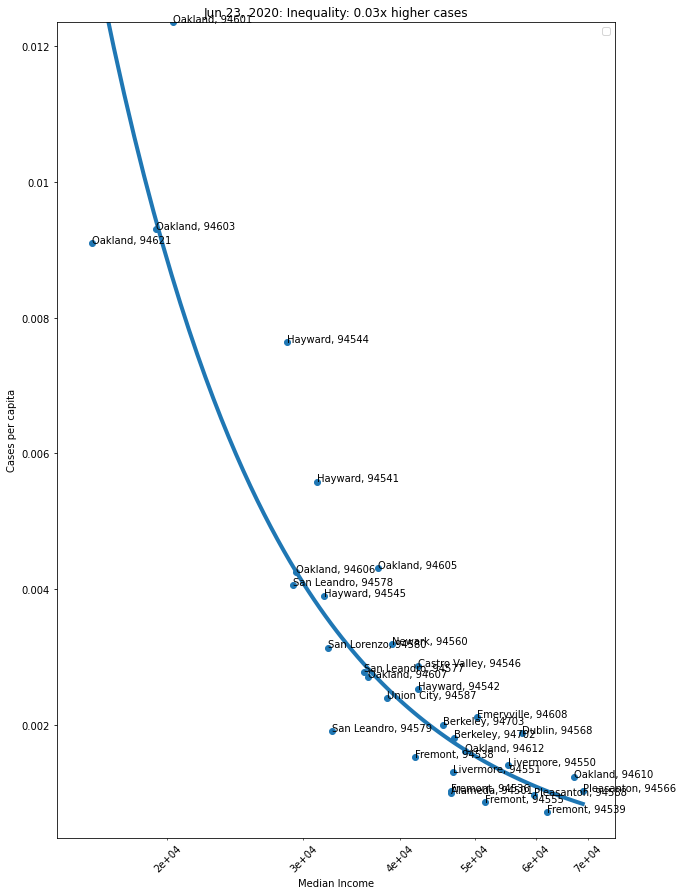

In [36]:
for x_col in [
    'Fraction of population that is Black',
    'Fraction of population that is Latino',
    'Fraction of population that is Asian',
    'Fraction of population that is White',
   'Fraction of population that is Black or Other',
   'Fraction of population that is Asian or White',
   'Fraction of population that is Non-Asian and Non-White',
   'Fraction of Non-Asian population that is Non-White',
    'Fraction non-white collar',
     'Median Income',
]:
    for y_col in ['Cases per capita']:
        plt.clf()
        fit_locations = pos_zip_alameda_df[
            (pos_zip_alameda_df['Cases'] >= 25)
            & (~pos_zip_alameda_df['Location'].isin(['94619', '94704', '94611', '94602']))]
        animated_power_law_plot(fit_locations, x_col, y_col, y_log_scale=False, save_fig_path=True)

In [448]:
np.power(6, 0.6)

2.930156051583521